In [1]:
import sys
print(sys.version)

3.6.5 |Anaconda custom (64-bit)| (default, Mar 29 2018, 13:14:23) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [7]:
"""
First created on October 14, 2018
@author: Neven Caplar
@contact: ncaplar@princeton.edu
"""

'\nFirst created on October 14, 2018\n@author: Neven Caplar\n@contact: ncaplar@princeton.edu\n'

In [3]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [4]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [13]:
#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 16})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

import os
import numpy as np
import astropy
import pandas as pd
from tqdm import tqdm
import pickle
import scipy
from sklearn.metrics.pairwise import euclidean_distances
from scipy import signal
import astropy
from astropy.io import fits
import warnings
warnings.filterwarnings('ignore')

from astropy import units as u
from astropy.coordinates import SkyCoord

# if you are not currently in the github directory, provide the path 
# for example MAIN_DIRECTORY='/Users/nevencaplar/Documents/Variability/NonStationarity'
MAIN_DIRECTORY=os.getcwd()
DATA_DIRECTORY=MAIN_DIRECTORY+'/Data/'
FIGURES_PNG_DIRECTORY=MAIN_DIRECTORY+'/Figures_png/'
FIGURES_PDF_DIRECTORY=MAIN_DIRECTORY+'/Figures_pdf/'

from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 10})


In [6]:
%load_ext autoreload
%autoreload 2

from NonStationarity import *

# Collecting the data 

## Finding RA/Dec coordinate of SDSS QSO

In [7]:
# This is dr7 qso catalog from https://classic.sdss.org/dr7/products/value_added/qsocat_dr7.html
# ``Skipping line'' warning is ok, even though it looks horrible - we just lose relativly small fraction of QSO which could not be read
dr7 = pd.read_csv(DATA_DIRECTORY+'dr7qso.dat',skiprows=80,sep='\s+',engine='python', error_bad_lines=False, warn_bad_lines=False,header=None )
# position of QSO in DR7
Positions_of_dr7=np.transpose([dr7[1].values,dr7[2].values])

In [8]:
#extract ra and dec values for the upcoming SQL query of HSC catalog

PositionOfQuasars = np.zeros(len(Positions_of_dr7), dtype={'names':('ra', 'dec'),
                          'formats':('f8','f8')})

PositionOfQuasars['ra'] = Positions_of_dr7[:,0]
PositionOfQuasars['dec'] =  Positions_of_dr7[:,1]

np.save(DATA_DIRECTORY+'PositionOfQuasars',PositionOfQuasars)

## Querying HSC database

In [ ]:
#############################
# For this you will have to go outside notebook and run the command in ``normal'' python

# In terminal, navigate to DATA_DIRECTORY and run command seen at the bottom of this comment 
# !!! Run the command in Python 2 !!!
# This is code which I modified from https://hsc-gitlab.mtk.nao.ac.jp/snippets/13
# This query creates the table that we import in the analysis part below (so it can be skipped if you just want to just analyze result of this query).
# The run time is around 3 hours

#'python CatalogCreator_sustom.py PositionOfQuasars.npy' 

#############################

## Constructing ``fake AGN'' sample

In [10]:
# Load the catalog with the selection of non-variable Stripe 82 stars 
# you can get it, using terminal, with:
# curl -O http://www.astro.washington.edu/users/ivezic/sdss/catalogs/stripe82calibStars_v2.6.dat.gz
# gunzip stripe82calibStars_v2.6.dat.gz
#

Stripe82stars= pd.read_csv('/Users/nevencaplar/Downloads/stripe82calibStars_v2.6.dat',skiprows=41,sep='\s+',engine='python', error_bad_lines=False, header=None )

# take only several columns
# ra, dec, g, err_g, r, err_r, i, err_i
Stripe82stars_likedr7=np.array(Stripe82stars.iloc[:,[1,2,15,16,21,22,27,28]])

# note that the columns in ``Stripe82stars_likedr7''are NOT exectly like  in dr7
Stripe82stars_likedr7=Stripe82stars_likedr7.view(np.float64)

# further selection, because HSC did not cover entire Stripe82
Stripe82stars_likedr7=np.concatenate((Stripe82stars_likedr7[((Stripe82stars_likedr7[:,0]>0) & (Stripe82stars_likedr7[:,0]<3))],\
                                      Stripe82stars_likedr7[((Stripe82stars_likedr7[:,0]>15) & (Stripe82stars_likedr7[:,0]<23.5) & (Stripe82stars_likedr7[:,1]>-1.1))],\
                                      Stripe82stars_likedr7[((Stripe82stars_likedr7[:,0]>28) & (Stripe82stars_likedr7[:,0]<37)& (Stripe82stars_likedr7[:,1]<-0.8))],\
                                      Stripe82stars_likedr7[Stripe82stars_likedr7[:,0]>330]))

# how many stars have been selected
print('how many stars have been selected: '+str(len(Stripe82stars_likedr7)))

how many stars have been selected: 308630


### Cleaning with Million QSO catalog

In [14]:
# This is from the Million qso catalog from https://heasarc.gsfc.nasa.gov/W3Browse/galaxy-catalog/milliquas.html
# We have selected all QSO with DEC between -1.5 and 1.5 deg 
mil_qso = pd.read_csv(DATA_DIRECTORY+'BrowseTargets.8558.1569111088',skiprows=4,sep='|',engine='python', error_bad_lines=False, warn_bad_lines=False, header=None )

In [15]:
# Positions of extracted qso
Positions_of_mil_qso=np.transpose([mil_qso[2].values,mil_qso[3].values])

In [18]:
# Transforming the coordintates in the degrees form that we use elsewhere in the notebook
# Takes around 4 min on my laptop
Positions_of_mil_qso_in_deg=[]
for i in tqdm(range(1,len(Positions_of_mil_qso))):
    c = SkyCoord(Positions_of_mil_qso[i][0]+' '+Positions_of_mil_qso[i][1], unit=(u.hourangle, u.deg))
    coordinate_in_deg_str=str.split(c.to_string())
    coordinate_in_deg=[float(coordinate_in_deg_str[0]),float(coordinate_in_deg_str[1])]
    Positions_of_mil_qso_in_deg.append(coordinate_in_deg)
    
Positions_of_mil_qso_in_deg=np.array(Positions_of_mil_qso_in_deg)  

100%|██████████| 124998/124998 [03:48<00:00, 547.48it/s]


In [19]:
# Extracting only QSO that are in covered area of Stripe82
Positions_of_mil_qso_in_deg_in_Stripe82=np.concatenate((Positions_of_mil_qso_in_deg[((Positions_of_mil_qso_in_deg[:,0]>0) & (Positions_of_mil_qso_in_deg[:,0]<3))],\
                                      Positions_of_mil_qso_in_deg[((Positions_of_mil_qso_in_deg[:,0]>15) & (Positions_of_mil_qso_in_deg[:,0]<23.5) & (Positions_of_mil_qso_in_deg[:,1]>-1.1))],\
                                      Positions_of_mil_qso_in_deg[((Positions_of_mil_qso_in_deg[:,0]>28) & (Positions_of_mil_qso_in_deg[:,0]<37)& (Positions_of_mil_qso_in_deg[:,1]<-0.8))],\
                                      Positions_of_mil_qso_in_deg[Positions_of_mil_qso_in_deg[:,0]>330]))

In [21]:
# Find index of all objects from the star catalog, which are also in the Million QSO catalog
# Takes around 3 min on my laptop
index_of_stars_which_are_QSO=[]
for j in tqdm(range(len(Positions_of_mil_qso_in_deg_in_Stripe82))):
    # find distances from the qso to the sample of nonvariable stars
    PositionOfQuasar_to_stars=(euclidean_distances([Positions_of_mil_qso_in_deg_in_Stripe82[:,[0,1]][j]],Stripe82stars_likedr7[:,[0,1]],))
    # if you found a hit (distance is very small), record the index of the object from star catalog so we can remove it later
    if np.min(PositionOfQuasar_to_stars)<0.001:
        index_of_stars_which_are_QSO.append(np.where(PositionOfQuasar_to_stars<0.001)[1][0])

100%|██████████| 25142/25142 [03:07<00:00, 134.36it/s]


In [22]:
# number of objects from the star catalog that we will remove
len(index_of_stars_which_are_QSO)

1692

In [23]:
# create new array which contains only objects which are not in Million QSO catalog
index_for_Stripe82stars_likedr7_which_are_stars=np.setdiff1d(range(len(Stripe82stars_likedr7)),index_of_stars_which_are_QSO)
Stripe82stars_likedr7_filtered=Stripe82stars_likedr7[index_for_Stripe82stars_likedr7_which_are_stars]

### Cleaning with QSO DR7 catalog

In [29]:
# There are 3 AGN which do not get cleaned if we Million QSO catalog, but which are in DR7 catalog
# so we do exactly the same thing with the dr7 catalog
Positions_of_dr7_in_Stripe82=np.concatenate((Positions_of_dr7[((Positions_of_dr7[:,0]>0) & (Positions_of_dr7[:,0]<3))],\
                                      Positions_of_dr7[((Positions_of_dr7[:,0]>15) & (Positions_of_dr7[:,0]<23.5) & (Positions_of_dr7[:,1]>-1.1))],\
                                      Positions_of_dr7[((Positions_of_dr7[:,0]>28) & (Positions_of_dr7[:,0]<37)& (Positions_of_dr7[:,1]<-0.8))],\
                                      Positions_of_dr7[Positions_of_dr7[:,0]>330]))

In [30]:
index_of_stars_which_are_QSO_second_filtered=[]
for j in tqdm(range(len(Positions_of_dr7_in_Stripe82))):
    # find distances from the qso to the sample of nonvariable stars
    PositionOfQuasar_to_stars=(euclidean_distances([Positions_of_dr7_in_Stripe82[:,[0,1]][j]],Stripe82stars_likedr7_filtered[:,[0,1]],))
    if np.min(PositionOfQuasar_to_stars)<0.001:
        index_of_stars_which_are_QSO_second_filtered.append(np.where(PositionOfQuasar_to_stars<0.001)[1][0])

100%|██████████| 6090/6090 [00:53<00:00, 113.88it/s]


In [32]:
# number of QSO which were removed in this second filtration
len(index_of_stars_which_are_QSO_second_filtered)

3

In [33]:
# create new array which contains only objects which are not in Million QSO catalog nor in DR7
index_for_Stripe82stars_likedr7_filtered_which_are_stars=np.setdiff1d(range(len(Stripe82stars_likedr7_filtered)),index_of_stars_which_are_QSO_second_filtered)
Stripe82stars_likedr7_double_filtered=Stripe82stars_likedr7_filtered[index_for_Stripe82stars_likedr7_filtered_which_are_stars]

In [165]:
# save for future reference
np.save(DATA_DIRECTORY+'Stripe82stars_likedr7_double_filtered',Stripe82stars_likedr7_double_filtered)

### continue

In [24]:
# we load again the QSO data
data=np.load(DATA_DIRECTORY+"matched_array_filtered.npy")

# Lets take out only the columns that we need from the full array contaning all of the QSO data
# same as in ``Stripe82stars_likedr7'' but has also information about redshift
# ra, dec,redshift, g (SDSS), err_g, r (SDSS), err_r, i (SDSS), err_i
datadr7_selection=data[:,[1,2,3,4,5,6,7,8,9]]


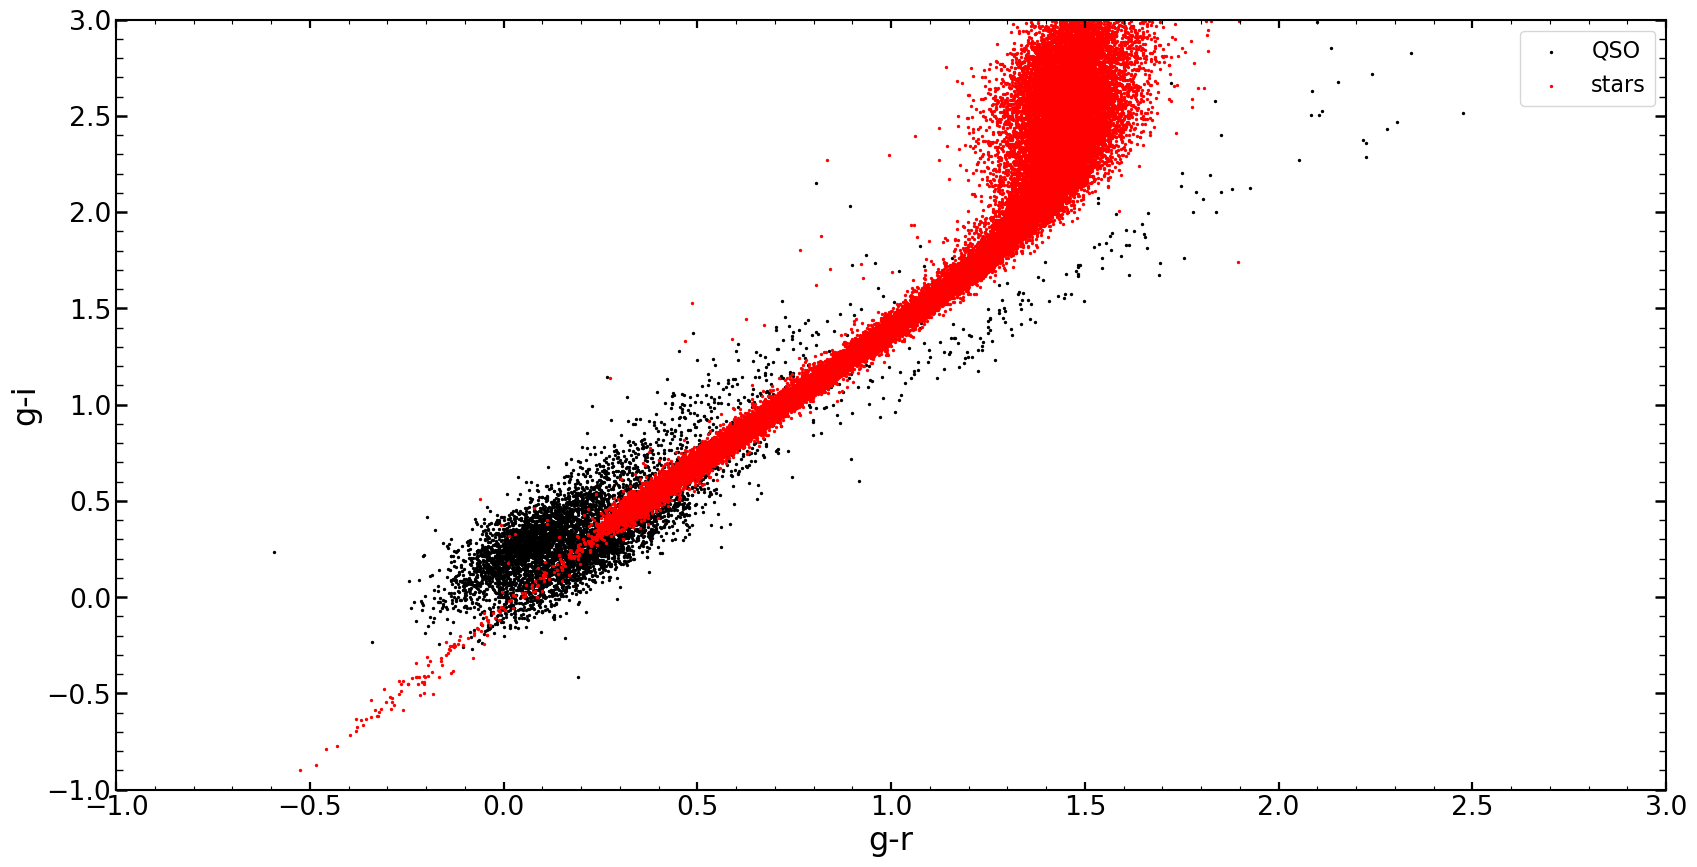

In [31]:
# comparison of these two datasets in color-color space
# this only shows small subset of all avaliable stars - the overlaps is better when looking at the whole avaliable sample of stars
plt.figure(figsize=(20,10))

plt.scatter(datadr7_selection[:,3]-datadr7_selection[:,5],datadr7_selection[:,3]-datadr7_selection[:,7],s=2,color='black',label='QSO')
plt.scatter(Stripe82stars.iloc[:,15].values[:50000]-Stripe82stars.iloc[:,21].values[:50000],Stripe82stars.iloc[:,15].values[:50000]-Stripe82stars.iloc[:,27].values[:50000],s=2,color='red',label='stars')
plt.xlabel('g-r')
plt.ylabel('g-i')
plt.xlim(-1,3)
plt.ylim(-1,3)
plt.legend()


In [40]:
# takes 2 minutes on my laptop


# small function to help quickly find n-th smallest member of an array  
def find_nth_smallest_proper_way(a, n):
    return np.partition(a, n-1)[n-1]

res_matching=[]
list_of_shortest_distance_for_checking=[]
for j in tqdm(range(len(datadr7_selection))):
    # finds distance from jth objects in datadr7_selection catalogue (selection of quasars) from the calibration stars in Stripe82
    # this is in the color space!
    PositionOfQuasars_euclidean_distances=euclidean_distances([datadr7_selection[:,[3,5,7]][j]],Stripe82stars_likedr7_double_filtered[:,[2,4,6]],)
    # find 5 shortest distance for each QSO
    shortest_distance_0=find_nth_smallest_proper_way(PositionOfQuasars_euclidean_distances[0],1)
    shortest_distance_1=find_nth_smallest_proper_way(PositionOfQuasars_euclidean_distances[0],2)
    shortest_distance_2=find_nth_smallest_proper_way(PositionOfQuasars_euclidean_distances[0],3)
    shortest_distance_3=find_nth_smallest_proper_way(PositionOfQuasars_euclidean_distances[0],4)
    shortest_distance_4=find_nth_smallest_proper_way(PositionOfQuasars_euclidean_distances[0],5)
    # find elements of the ``Stripe82stars_likedr7'' that have these shortest distance to the element datadr7_selection
    shortest_distance_index_0=np.where(PositionOfQuasars_euclidean_distances[0]==shortest_distance_0)[0][0]
    shortest_distance_index_1=np.where(PositionOfQuasars_euclidean_distances[0]==shortest_distance_1)[0][0]
    shortest_distance_index_2=np.where(PositionOfQuasars_euclidean_distances[0]==shortest_distance_2)[0][0]
    shortest_distance_index_3=np.where(PositionOfQuasars_euclidean_distances[0]==shortest_distance_3)[0][0]
    shortest_distance_index_4=np.where(PositionOfQuasars_euclidean_distances[0]==shortest_distance_4)[0][0]
    # append them to array
    res_matching.append([shortest_distance_0,Stripe82stars_likedr7_double_filtered[shortest_distance_index_0]])
    res_matching.append([shortest_distance_1,Stripe82stars_likedr7_double_filtered[shortest_distance_index_1]])
    res_matching.append([shortest_distance_2,Stripe82stars_likedr7_double_filtered[shortest_distance_index_2]])
    res_matching.append([shortest_distance_3,Stripe82stars_likedr7_double_filtered[shortest_distance_index_3]])
    res_matching.append([shortest_distance_4,Stripe82stars_likedr7_double_filtered[shortest_distance_index_4]])
    
    list_of_shortest_distance_for_checking.append(shortest_distance_0)
    

# create array contaning all of the matched stars    
matched_array=[]    
for j in range(len(res_matching)):
    matched_array.append(res_matching[j][1])
    
matched_array_Stripe82_stars_to_dr7QSO=np.array(matched_array)

100%|██████████| 5919/5919 [02:09<00:00, 45.77it/s]


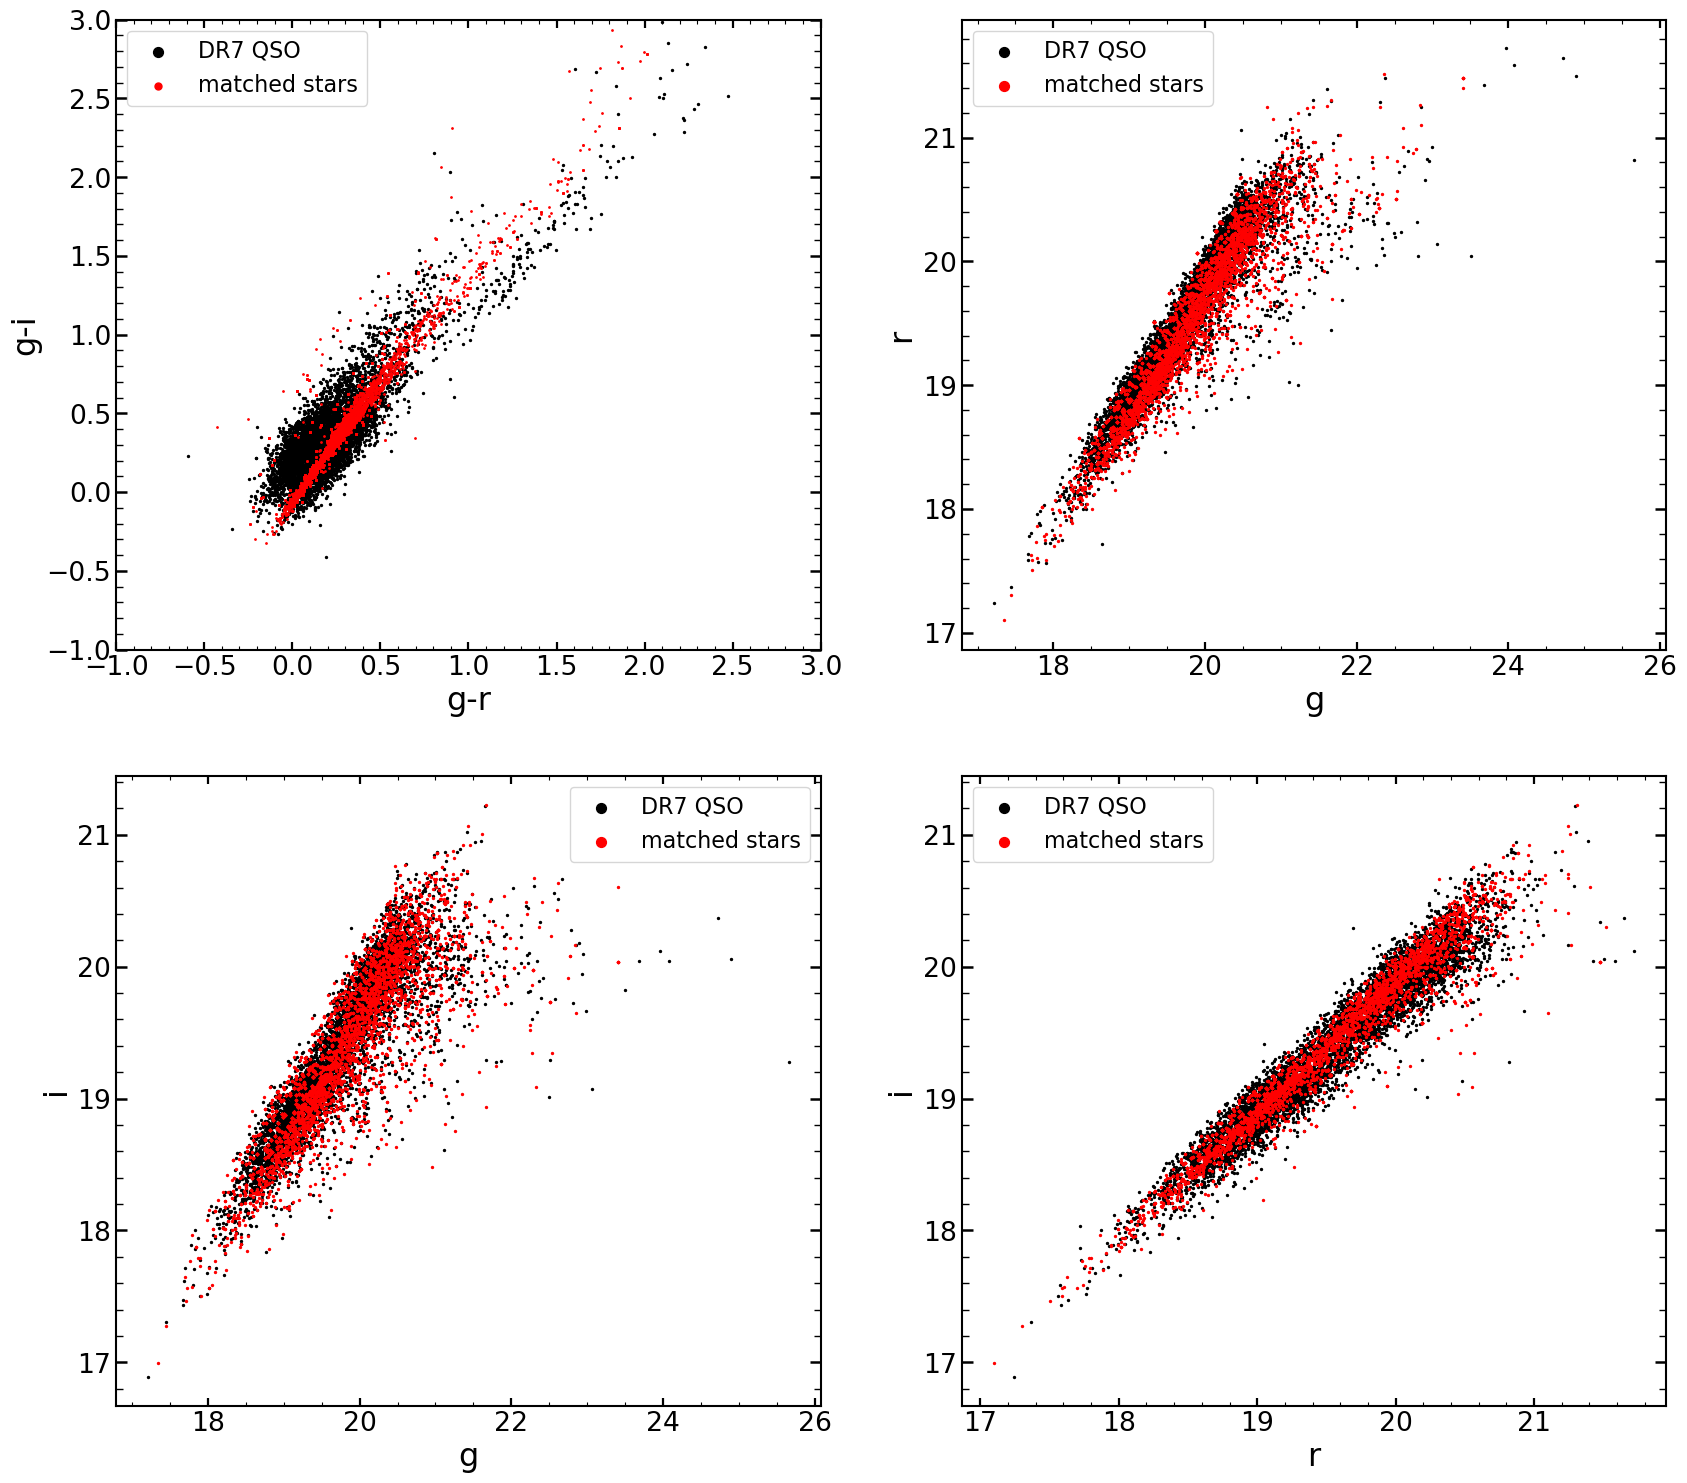

In [41]:
# figure showing the matching between QSO and stars
plt.figure(figsize=(20,18))

plt.subplot(2,2,1)
plt.scatter(datadr7_selection[:,3]-datadr7_selection[:,5],datadr7_selection[:,3]-datadr7_selection[:,7],s=2,label='DR7 QSO',color='black')
plt.scatter(matched_array_Stripe82_stars_to_dr7QSO[:,2]-matched_array_Stripe82_stars_to_dr7QSO[:,4]
            ,matched_array_Stripe82_stars_to_dr7QSO[:,2]-matched_array_Stripe82_stars_to_dr7QSO[:,6],s=1,label='matched stars',color='red')
plt.xlabel('g-r')
plt.ylabel('g-i')
plt.xlim(-1,3)
plt.ylim(-1,3)
plt.legend(markerscale=5)

plt.subplot(2,2,2)
plt.scatter(datadr7_selection[:,3],datadr7_selection[:,5],s=2,label='DR7 QSO',color='black')
plt.scatter(matched_array_Stripe82_stars_to_dr7QSO[:,2],matched_array_Stripe82_stars_to_dr7QSO[:,4],s=2,label='matched stars',color='red')
plt.xlabel('g')
plt.ylabel('r')
#plt.xlim(-1,5)
#plt.ylim(-1,5)
plt.legend(markerscale=5)

plt.subplot(2,2,3)
plt.scatter(datadr7_selection[:,3],datadr7_selection[:,7],s=2,label='DR7 QSO',color='black')
plt.scatter(matched_array_Stripe82_stars_to_dr7QSO[:,2],matched_array_Stripe82_stars_to_dr7QSO[:,6],s=2,label='matched stars',color='red')
plt.xlabel('g')
plt.ylabel('i')
#plt.xlim(-1,5)
#plt.ylim(-1,5)
plt.legend(markerscale=5)

plt.subplot(2,2,4)
plt.scatter(datadr7_selection[:,5],datadr7_selection[:,7],s=2,label='DR7 QSO',color='black')
plt.scatter(matched_array_Stripe82_stars_to_dr7QSO[:,4],matched_array_Stripe82_stars_to_dr7QSO[:,6],s=2,label='matched stars',color='red')
plt.xlabel('r')
plt.ylabel('i')
#plt.xlim(-1,5)
#plt.ylim(-1,5)
plt.legend(markerscale=5)

plt.savefig(FIGURES_PDF_DIRECTORY + 'comaprison_stars_AGN_color_color.pdf', bbox_inches='tight')
plt.savefig(FIGURES_PNG_DIRECTORY + 'comaprison_stars_AGN_color_color.png', bbox_inches='tight')

In [46]:
# after confirming that is looks good, save the data
np.save(DATA_DIRECTORY+'matched_array_Stripe82_stars_to_dr7QSO',matched_array_Stripe82_stars_to_dr7QSO)

In [166]:
#extract ra and dec values for SQL query
data= np.zeros(len(matched_array_Stripe82_stars_to_dr7QSO), dtype={'names':('ra', 'dec'),
                          'formats':('f8','f8')})

data['ra'] = matched_array_Stripe82_stars_to_dr7QSO[:,0]
data['dec'] =  matched_array_Stripe82_stars_to_dr7QSO[:,1]

position_of_matched_array_Stripe82_stars_to_dr7QSO=data

np.save(DATA_DIRECTORY+'position_of_matched_array_Stripe82_stars_to_dr7QSO',\
        position_of_matched_array_Stripe82_stars_to_dr7QSO)

## Querying HSC database for ``fake AGN'' that will make control sample

In [ ]:
# Follow same instructions as before
# This run took 1 hour, 40 minutes

# run the following command in order to create sql query
# print('python CatalogCreator_custom.py position_of_matched_array_Stripe82_stars_to_dr7QSO.npy')

## Adding time-separation information 

### Finding patch information for each AGN

In [ ]:
# It is somewhat tricky to find when the observations of AGN have been taken 
# We have to first find in which ``patch'' and ``tract'' of the sky every AGN is observed
# Create this SQL query and run it

file = open(DATA_DIRECTORY+'sql_get_patch_from_object_id','w') 
file.write("SELECT \n")
file.write("    object_id \n")
file.write("    ,ra \n") 
file.write("    ,dec \n")
file.write("    ,patch_s  \n")
file.write("    ,tract  \n")
file.write("FROM  \n") 
file.write("    s18a_wide.forced \n") 
file.write("WHERE \n")
for i in range(len(matched_array_filtered[:,-1])):
    if i==0:
        file.write("    object_id="+str(int(matched_array_filtered[:,-1][i]))+" \n")    
    else:
        file.write("    OR  object_id="+str(int(matched_array_filtered[:,-1][i]))+" \n")                       
file.write("; \n") 
file.close()   

In [91]:
# read in catalogue from the resulting HSC query with pandas
patch_info_for_matched_array_filtered = pd.read_csv(DATA_DIRECTORY+'281732.csv')

In [ ]:
# now, we want to find the time when each ``patch'' and ``tract'' of the sky was observed
# so we create SQL query for tha as well

file = open('/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/sql_get_time_from_patch','w') 
file.write("SELECT \n")
file.write("    warped.skymap_id \n")
file.write("    ,warped.tract \n") 
file.write("    ,warped.patch \n")
file.write("    ,warped.mjd  \n")
file.write("    ,warped.taiobs  \n")
file.write("FROM  \n") 
file.write("    s18a_wide.warped \n") 
file.write("WHERE \n")
for i in range(len(patch_info_for_matched_array_filtered)):
    if i==0:
        file.write("    tract="+str(int(patch_info_for_matched_array_filtered.iloc[i]['tract']))+" AND patch='"+patch_info_for_matched_array_filtered.iloc[i]['patch_s']+"' AND filter01='HSC-G' \n")    
    else:
        file.write("    OR tract="+str(int(patch_info_for_matched_array_filtered.iloc[i]['tract']))+" AND patch='"+patch_info_for_matched_array_filtered.iloc[i]['patch_s']+"' AND filter01='HSC-G' \n")                  
file.write("; \n") 
file.close() 

In [92]:
# read in catalogue from the resulting HSC query with pandas
time_info_for_patch = pd.read_csv(DATA_DIRECTORY+'281734.csv')

### Finding out time difference between observations 

In [93]:
# for each object from ``matched_array_filtered'' find its patch number and then times (MJD values) when that patch and tract was observed 
# takes around 20 seconds on my laptop
times_for_matched_array_filtered_g=[]
for i in tqdm(range(len(matched_array_filtered))):
    matched_array_filtered_object_id_single_object=int(matched_array_filtered[i][-1])
    single_patch_info=(patch_info_for_matched_array_filtered)[(patch_info_for_matched_array_filtered['# object_id'].values)==\
                                                              matched_array_filtered_object_id_single_object]
    if len(single_patch_info)==0:
        times_for_matched_array_filtered_g.append(np.array([-99]))
    else:
        times_for_matched_array_filtered_g.append(time_info_for_patch[(time_info_for_patch['tract']==single_patch_info['tract'].values[0])\
                                                                      &(time_info_for_patch['patch']==single_patch_info['patch_s'].values[0])]['mjd'].values)
        
# turn it into an array        
times_for_matched_array_filtered_g=np.array(times_for_matched_array_filtered_g)

100%|██████████| 5919/5919 [00:22<00:00, 262.95it/s]


In [94]:
# take mean/median of all of the times when an AGN was observed
median_times_for_matched_array_filtered_g=[]
mean_times_for_matched_array_filtered_g=[]
for i in range(len(times_for_matched_array_filtered_g)):
    mean_times_for_matched_array_filtered_g.append(np.mean(times_for_matched_array_filtered_g[i]))
    median_times_for_matched_array_filtered_g.append(np.median(times_for_matched_array_filtered_g[i]))
    
mean_times_for_matched_array_filtered_g=np.array(mean_times_for_matched_array_filtered_g)
median_times_for_matched_array_filtered_g=np.array(median_times_for_matched_array_filtered_g)

In [96]:
# now we have to match objects from SDSS and HSC
# we match them according to their SDSS ID
SDSS_ids_of_selected_objects_in_matched_array_filtered=matched_array_filtered[:,0]

time_difference_between_observations_in_g_band_SDSS_mean_HSC=[]
for i in tqdm(range(len(matched_array_filtered))):
    # observation time is column number 45 in dr7 dataframe
    time_difference_between_observations_in_g_band_SDSS_mean_HSC.append(mean_times_for_matched_array_filtered_g[i]-\
                                                                        dr7[dr7.iloc[:,0].values==SDSS_ids_of_selected_objects_in_matched_array_filtered[i]][45].values[0])
# turn the result into an array
time_difference_between_observations_in_g_band_SDSS_mean_HSC=np.array(time_difference_between_observations_in_g_band_SDSS_mean_HSC)

# and export
np.save(DATA_DIRECTORY+'time_difference_between_observations_in_g_band_SDSS_mean_HSC',time_difference_between_observations_in_g_band_SDSS_mean_HSC)

100%|██████████| 5919/5919 [00:29<00:00, 202.10it/s]


# Analysis of the output from HSC for QSO selected in SDSS

## Initial analysis

In [37]:
# Read in the output from the HSC query
# in my case it got named ``194782.csv''
df = pd.read_csv(DATA_DIRECTORY+'194782.csv')

# Get positions of the found QSO
Positions_of_df=np.transpose([df['# ra'].values,df['dec'].values])

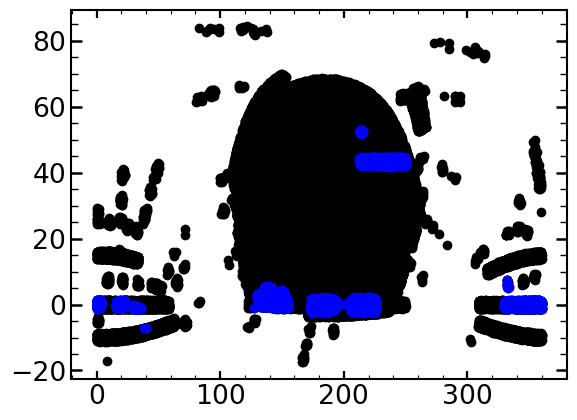

In [39]:
# check the overlap with SDSS
# import dr7 (at the start of section 1), if you skipped section 1


# blue for HSC QSO and black for SDSS QSO
plt.scatter(Positions_of_dr7[:,0],Positions_of_dr7[:,1],color='black')
plt.scatter(Positions_of_df[:,0],Positions_of_df[:,1],color='blue')


plt.savefig(FIGURES_PDF_DIRECTORY + 'SDSS_HSC_coverage.pdf', bbox_inches='tight')
plt.savefig(FIGURES_PNG_DIRECTORY + 'SDSS_HSC_coverage.png', bbox_inches='tight')

In [40]:
# takes a bit less than 1 minute on my laptop
# this matches QSO from SDSS and QSO from the HSC catalog (search positions being set by the positions in the SDSS catalog)
res_matching=[]
for j in tqdm(range(len(Positions_of_dr7))):
    # finds distance from each of the objects in dr7 catalogue from the objects in HSC catalogue
    PositionOfQuasars_euclidean_distances=euclidean_distances([Positions_of_dr7[j]],Positions_of_df)
    # shortest distance
    shortest_distance=np.min(PositionOfQuasars_euclidean_distances[0])
    # element of the ``Positions_of_df'' that has the shortest distance to the SDSS QSO
    shortest_distance_index=np.where(PositionOfQuasars_euclidean_distances[0]==np.min(PositionOfQuasars_euclidean_distances[0]))[0][0]
    res_matching.append([shortest_distance,df.loc[shortest_distance_index].values])

100%|██████████| 105645/105645 [00:55<00:00, 1898.42it/s]


In [41]:
# create array that has objects from SDSS that are found in HSC

matched_array=[]
matched_array_extended_SDSS=[]
for i in tqdm(range(len(res_matching))):
    if res_matching[i][0]>0.001:
        pass
    else:
        # extract columns 0,1,2,3,6,7,8,9,10,11 from SDSS, which are SDSS ID, ra, dec, redshift and \
        # psf magnitude and its associated error in different bands (g->[6,7],r->[8,9],i->[10,11])
        matched_array.append(np.concatenate((dr7.loc[i][[0,1,2,3,6,7,8,9,10,11]],res_matching[i][1])))

matched_array=np.array(matched_array)

100%|██████████| 105645/105645 [00:05<00:00, 17771.57it/s]


In [42]:
# filter out few QSO which have a failed measurment in SDSS (g-band set at 0 in SDSS catalog)
matched_array_filtered=matched_array[matched_array[:,4]>16]


np.save(DATA_DIRECTORY+'matched_array' ,matched_array)
np.save(DATA_DIRECTORY+'matched_array_filtered' ,matched_array_filtered)


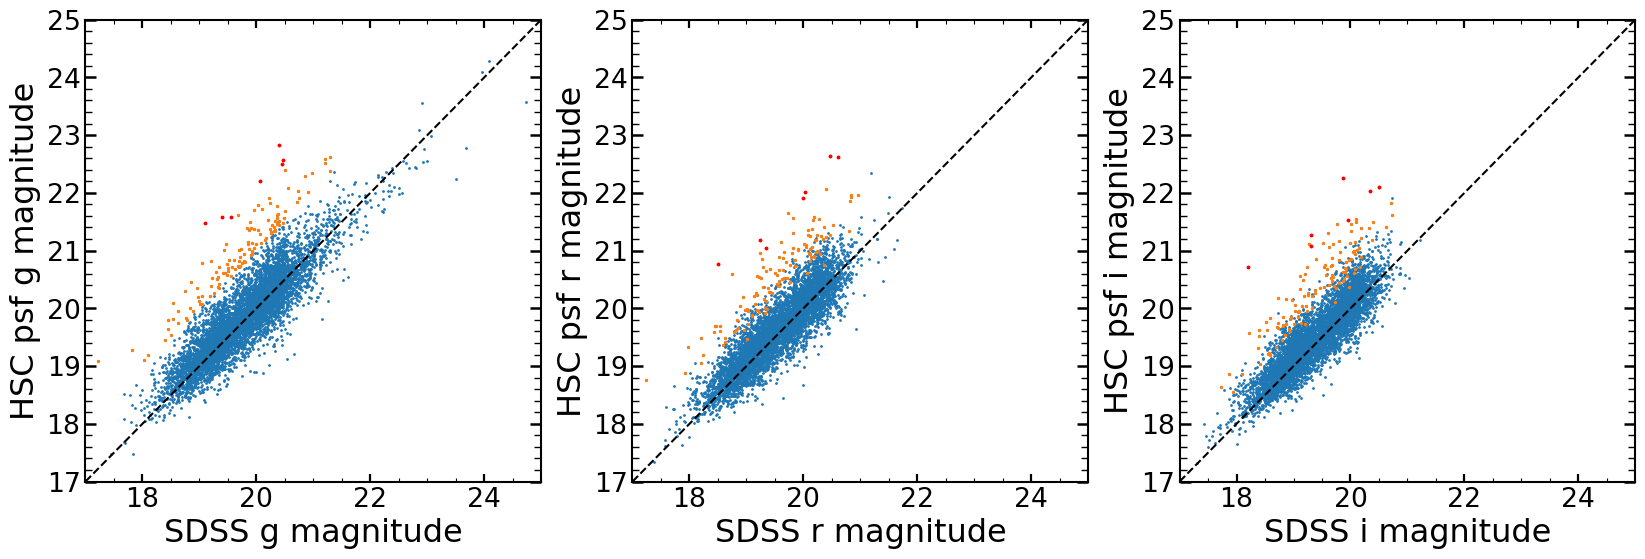

In [43]:
# plot differences between SDSS and HSC using psf values for magnitudes
# blue for points which are within 1 mag of each other
# orange for between 1 and 2 mag between two surveys
# red for difference larger than 2 mag

plt.figure(figsize=(20,6))
plt.subplot(131)

plt.scatter(matched_array_filtered[:,4],matched_array_filtered[:,14+4],s=1)
plt.scatter(matched_array_filtered[:,4][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>1],matched_array_filtered[:,14+4][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>1],s=2)
plt.scatter(matched_array_filtered[:,4][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>2],matched_array_filtered[:,14+4][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>2],s=3,color='red')

plt.xlabel('SDSS g magnitude')
plt.ylabel('HSC psf g magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)

plt.subplot(132)

plt.scatter(matched_array_filtered[:,6],matched_array_filtered[:,14+6],s=1)
plt.scatter(matched_array_filtered[:,6][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>1],matched_array_filtered[:,14+6][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>1],s=2)
plt.scatter(matched_array_filtered[:,6][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>2],matched_array_filtered[:,14+6][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>2],s=3,color='red')
plt.xlabel('SDSS r magnitude')
plt.ylabel('HSC psf r magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)
plt.subplot(133)

plt.scatter(matched_array_filtered[:,8],matched_array_filtered[:,14+8],s=1)
plt.scatter(matched_array_filtered[:,8][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>1],matched_array_filtered[:,14+8][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>1],s=2)
plt.scatter(matched_array_filtered[:,8][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>2],matched_array_filtered[:,14+8][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>2],s=3,color='red')
plt.xlabel('SDSS i magnitude')
plt.ylabel('HSC psf i magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)

plt.savefig(FIGURES_PDF_DIRECTORY + 'comaprison_SDSS_HSC_magnitudes.pdf', bbox_inches='tight')
plt.savefig(FIGURES_PNG_DIRECTORY + 'comaprison_SDSS_HSC_magnitudes.png', bbox_inches='tight')

## Median mass, Luminosity and Edd. ratio 

In [ ]:
# we want to see what is the depedence with mass, luminosity and Eddington ration in our sample,
# in particular after separting according to their brightness

In [50]:
# we load catalog with QSO properties from DR7
# http://quasar.astro.illinois.edu/BH_mass/dr7.htm 

dr7_bh_Shen=astropy.io.fits.open('/Users/nevencaplar/Documents/Variability/Lia_Data/dr7_bh_May01_2011.fits')[1].data

In [51]:
# we extract SDSS id, mass, luminosity and Edd. ratio
# takes around 30 seconds on my laptop
dr7_properties=[]
for i in tqdm(range(len(dr7_bh_Shen))):
    dr7_properties.append([dr7_bh_Shen[i][0],dr7_bh_Shen[i][3],dr7_bh_Shen[i][11],dr7_bh_Shen[i][138],dr7_bh_Shen[i][140]])
    
dr7_properties=np.array(dr7_properties)

100%|██████████| 105783/105783 [00:25<00:00, 4085.89it/s]


In [52]:
# we extend the ``matched_array_filtered'' array with the physical properties found in the previous cell
# takes around 20 seconds on my laptop
matched_array_filtered_dr7_extension=[]
for i in tqdm(range(len(matched_array_filtered))):
    matched_array_filtered_dr7_extension.append((dr7_properties[dr7_properties[:,0]==matched_array_filtered[i][0]])[0])
    
matched_array_filtered_dr7_extension=np.array(matched_array_filtered_dr7_extension)

100%|██████████| 5919/5919 [00:21<00:00, 272.07it/s]


In [53]:
# Do the analysis but also return SDSS ID of every AGN, so we can match it later
# This is done for g-band
res_delta_redshift_via_redshift_array,res_delta_redshift_via_redshift_median_array,\
res_delta_redshift_via_redshift_err_array,res_delta_redshift_via_redshift_median_err_array,\
res_redshift_array,p20_array,p20_median_array,median_mag_values_array,delta_g_and_redshift_and_g_and_SDSS_ID_sorted_by_redshift_g_and_split_sorted_by_g\
=create_redshift_result(matched_array_filtered,100,sdss_band_column=4,difference_sdss_HSC_columns=14,\
                        return_median_mag_values=True,separate_in_time_dif=False,time_dif_array=None,return_SDSS_ID=True)

In [54]:
# give SDSS ids in each redshift and luminosity bin
delta_g_res_extension=[]
for redshift_bin in range(len(delta_g_and_redshift_and_g_and_SDSS_ID_sorted_by_redshift_g_and_split_sorted_by_g)):
    single_redshift_bin=[]
    for lum_bin in range(len(delta_g_and_redshift_and_g_and_SDSS_ID_sorted_by_redshift_g_and_split_sorted_by_g[redshift_bin])):
        single_luminosity_bin=[]
        single_bin=delta_g_and_redshift_and_g_and_SDSS_ID_sorted_by_redshift_g_and_split_sorted_by_g[redshift_bin][lum_bin]
        single_bin_index=single_bin[:,3]

        for i in range(len(single_bin_index)):
            single_redshift_single_luminosity_bin=[]
            single_redshift_single_luminosity_bin.append((matched_array_filtered_dr7_extension[matched_array_filtered_dr7_extension[:,0]==single_bin_index[i]])[0])
            
            single_luminosity_bin.append(single_redshift_single_luminosity_bin[0])

        single_redshift_bin.append(single_luminosity_bin)

    delta_g_res_extension.append(single_redshift_bin)

In [55]:
# calculate median value of luminosity, mass and Edd. ratio in each bin
median_lum_values_array=[]
median_mas_values_array=[]
median_Edd_values_array=[]
for lum_bin in range(5):
    median_lum_at_single_redshift=[]
    median_mas_at_single_redshift=[]
    median_Edd_at_single_redshift=[]
    for redshift_bin in range(len(delta_g_res_extension)):
        median_lum_at_single_redshift.append(np.median(np.array(delta_g_res_extension[redshift_bin][lum_bin])[:,2].astype('float')))
        median_mas_at_single_redshift.append(np.median(np.array(delta_g_res_extension[redshift_bin][lum_bin])[:,3].astype('float')))
        median_Edd_at_single_redshift.append(np.median(np.array(delta_g_res_extension[redshift_bin][lum_bin])[:,4].astype('float')))
       
    median_lum_values_array.append(median_lum_at_single_redshift)
    median_mas_values_array.append(median_mas_at_single_redshift)
    median_Edd_values_array.append(median_Edd_at_single_redshift)

    
median_lum_values_array=np.array(median_lum_values_array)
median_mas_values_array=np.array(median_mas_values_array)
median_Edd_values_array=np.array(median_Edd_values_array)

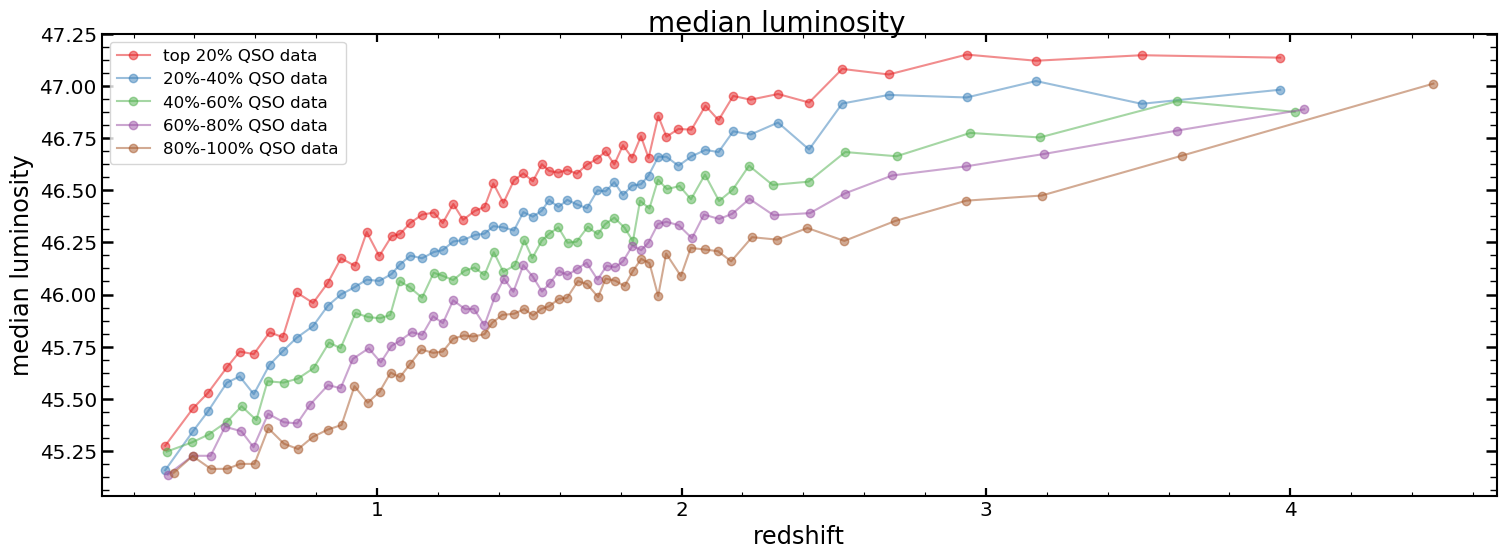

In [56]:
# Now, finally, lets look at the luminosity

matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
plt.suptitle('median luminosity',y=0.92,fontsize=20)

plt.plot(res_redshift_array[1],median_lum_values_array[0],ls='-',color='#e41a1c',alpha=0.5,label='top 20% QSO data',marker='o')
plt.plot(res_redshift_array[1],median_lum_values_array[1],ls='-',color='#377eb8',alpha=0.5,label='20%-40% QSO data',marker='o')
plt.plot(res_redshift_array[3],median_lum_values_array[2],ls='-',color='#4daf4a',alpha=0.5,label='40%-60% QSO data',marker='o')
plt.plot(res_redshift_array[4],median_lum_values_array[3],ls='-',color='#984ea3',alpha=0.5,label='60%-80% QSO data',marker='o')
plt.plot(res_redshift_array[5],median_lum_values_array[4],ls='-',color='#a65628',alpha=0.5,label='80%-100% QSO data',marker='o')

plt.ylabel('median luminosity')
plt.xlabel('redshift')
plt.legend()

plt.savefig(FIGURES_PDF_DIRECTORY + 'median_luminosity.pdf', bbox_inches='tight')
plt.savefig(FIGURES_PNG_DIRECTORY + 'median_luminosity.png', bbox_inches='tight')

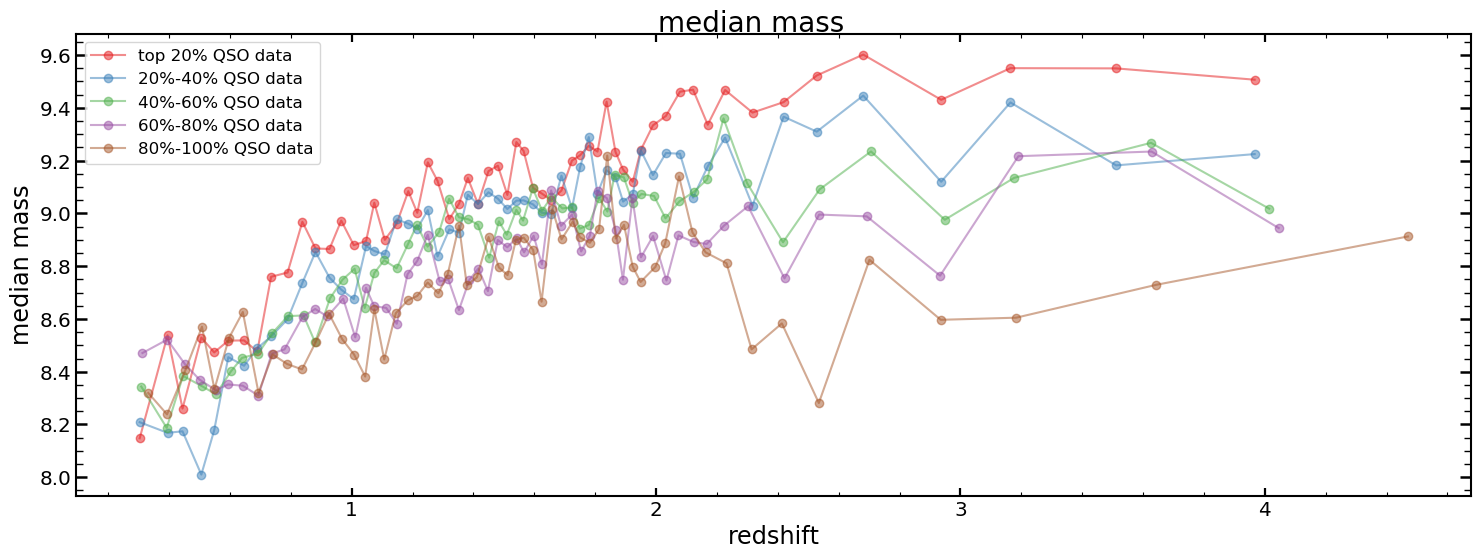

In [57]:
# then mass

matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
plt.suptitle('median mass',y=0.92,fontsize=20)

plt.plot(res_redshift_array[1],median_mas_values_array[0],ls='-',color='#e41a1c',alpha=0.5,label='top 20% QSO data',marker='o')
plt.plot(res_redshift_array[1],median_mas_values_array[1],ls='-',color='#377eb8',alpha=0.5,label='20%-40% QSO data',marker='o')
plt.plot(res_redshift_array[3],median_mas_values_array[2],ls='-',color='#4daf4a',alpha=0.5,label='40%-60% QSO data',marker='o')
plt.plot(res_redshift_array[4],median_mas_values_array[3],ls='-',color='#984ea3',alpha=0.5,label='60%-80% QSO data',marker='o')
plt.plot(res_redshift_array[5],median_mas_values_array[4],ls='-',color='#a65628',alpha=0.5,label='80%-100% QSO data',marker='o')

plt.ylabel('median mass')
plt.xlabel('redshift')

plt.legend()


plt.savefig(FIGURES_PDF_DIRECTORY + 'median_mass.pdf', bbox_inches='tight')
plt.savefig(FIGURES_PNG_DIRECTORY + 'median_mass.png', bbox_inches='tight')

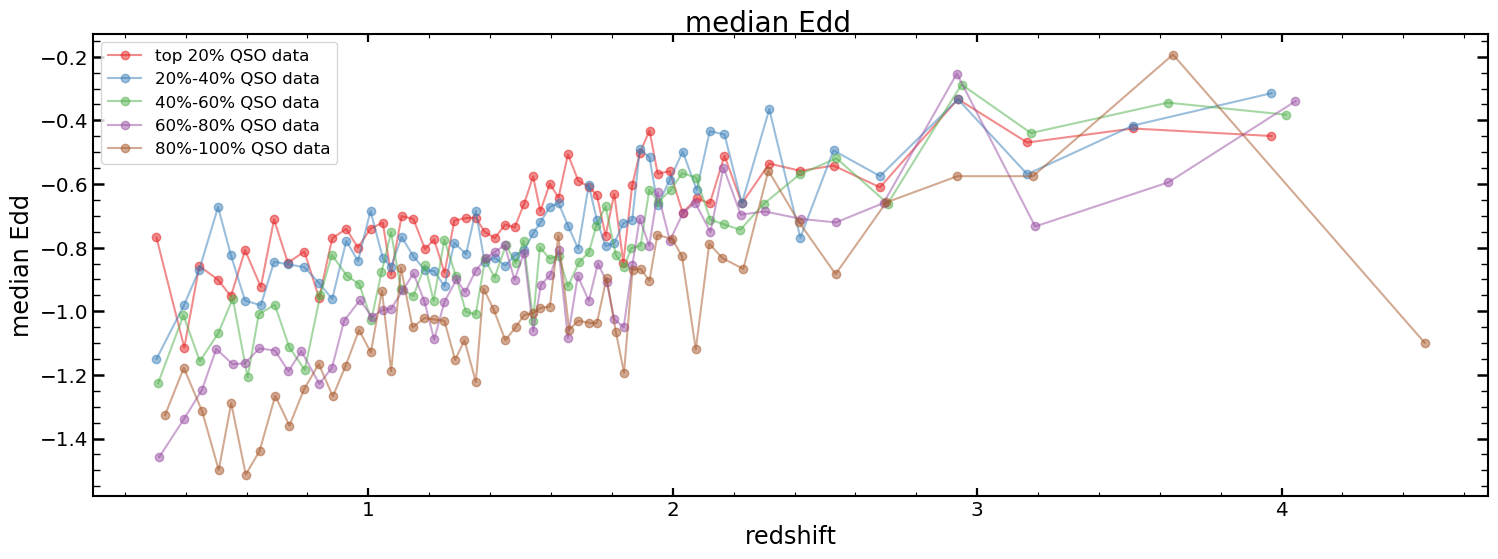

In [58]:
# and then Eddington ratio

matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
plt.suptitle('median Edd',y=0.92,fontsize=20)

plt.plot(res_redshift_array[1],median_Edd_values_array[0],ls='-',color='#e41a1c',alpha=0.5,label='top 20% QSO data',marker='o')
plt.plot(res_redshift_array[1],median_Edd_values_array[1],ls='-',color='#377eb8',alpha=0.5,label='20%-40% QSO data',marker='o')
plt.plot(res_redshift_array[3],median_Edd_values_array[2],ls='-',color='#4daf4a',alpha=0.5,label='40%-60% QSO data',marker='o')
plt.plot(res_redshift_array[4],median_Edd_values_array[3],ls='-',color='#984ea3',alpha=0.5,label='60%-80% QSO data',marker='o')
plt.plot(res_redshift_array[5],median_Edd_values_array[4],ls='-',color='#a65628',alpha=0.5,label='80%-100% QSO data',marker='o')

plt.ylabel('median Edd')
plt.xlabel('redshift')

plt.legend()

plt.savefig(FIGURES_PDF_DIRECTORY + 'median_Edd.pdf', bbox_inches='tight')
plt.savefig(FIGURES_PNG_DIRECTORY + 'median_Edd.png', bbox_inches='tight')

## Time difference between observations

In [59]:
# first we load the data
time_difference_between_observations_in_g_band_SDSS_mean_HSC=np.load(DATA_DIRECTORY+'time_difference_between_observations_in_g_band_SDSS_mean_HSC.npy')

In [60]:
# we separate the data in quantiles and calculate median times in the full dataset, and in the shortest or longest quantile
time_difference_between_observations_in_g_band_SDSS_mean_HSC_cleaned=time_difference_between_observations_in_g_band_SDSS_mean_HSC\
[time_difference_between_observations_in_g_band_SDSS_mean_HSC>0]

time_difference_quantiles=[np.quantile(time_difference_between_observations_in_g_band_SDSS_mean_HSC_cleaned,.20),\
                           np.quantile(time_difference_between_observations_in_g_band_SDSS_mean_HSC_cleaned,.40),\
                           np.quantile(time_difference_between_observations_in_g_band_SDSS_mean_HSC_cleaned,.60),\
                           np.quantile(time_difference_between_observations_in_g_band_SDSS_mean_HSC_cleaned,.80)]

print('median time difference is: '+str(np.median(time_difference_between_observations_in_g_band_SDSS_mean_HSC_cleaned/365.25))+' years')
print('median time difference for 20% shortest separations is: '+str(np.median((time_difference_between_observations_in_g_band_SDSS_mean_HSC_cleaned[time_difference_between_observations_in_g_band_SDSS_mean_HSC_cleaned<time_difference_quantiles[0]])/365.25))+' years')
print('median time difference for 20% longest separations is: '+str(np.median((time_difference_between_observations_in_g_band_SDSS_mean_HSC_cleaned[time_difference_between_observations_in_g_band_SDSS_mean_HSC_cleaned>time_difference_quantiles[-1]])/365.25))+' years')


median time difference is: 14.850495162378023 years
median time difference for 20% shortest separations is: 12.93796286842031 years
median time difference for 20% longest separations is: 16.89183176014073 years


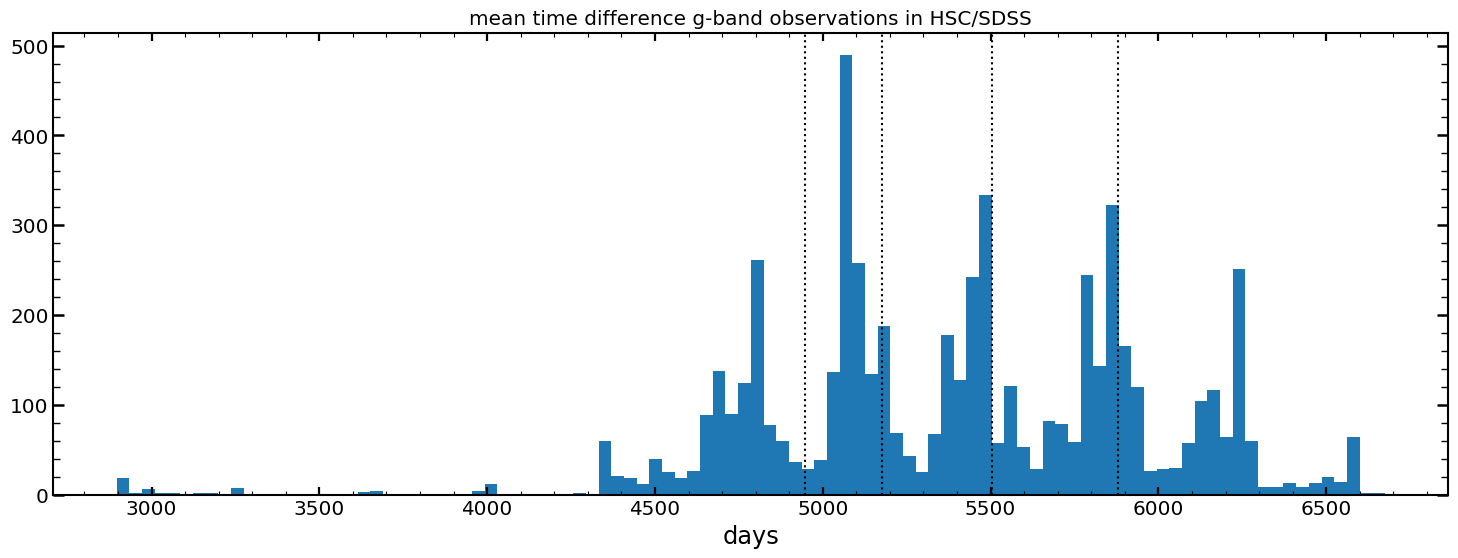

In [61]:
# time difference between two surveys
# dashed lines showing where the limits of quantiles are

plt.figure(figsize=(18,6))
plt.title("mean time difference g-band observations in HSC/SDSS")
plt.hist(time_difference_between_observations_in_g_band_SDSS_mean_HSC_cleaned,bins=100)
plt.xlabel('days')

plt.axvline(time_difference_quantiles[0],color='black',ls=':')
plt.axvline(time_difference_quantiles[1],color='black',ls=':')
plt.axvline(time_difference_quantiles[2],color='black',ls=':')
plt.axvline(time_difference_quantiles[3],color='black',ls=':')


plt.savefig(FIGURES_PDF_DIRECTORY + 'mean_time_difference.pdf', bbox_inches='tight')
plt.savefig(FIGURES_PNG_DIRECTORY + 'mean_time_difference.png', bbox_inches='tight')

# Analysis of the output from HSC for control sample

In [51]:
# load the array contaning the list of all nonvariable stars which went to HSC query and their positions
matched_array_Stripe82_stars_to_dr7QSO=np.load(DATA_DIRECTORY+'matched_array_Stripe82_stars_to_dr7QSO.npy')
#position_of_matched_array_Stripe82_stars_to_dr7QSO=O=np.load(DATA_DIRECTORY+'position_of_matched_array_Stripe82_stars_to_dr7QSO.npy')

In [53]:
# read in the results from the HSC query
df = pd.read_csv(DATA_DIRECTORY+'318658.csv')

In [54]:
# Extract ra and dec from both arrays
Positions_of_df=np.transpose([df['# ra'].values,df['dec'].values])
Positions_of_matched_array_Stripe82_stars_to_dr7QSO=matched_array_Stripe82_stars_to_dr7QSO[:,[0,1]]

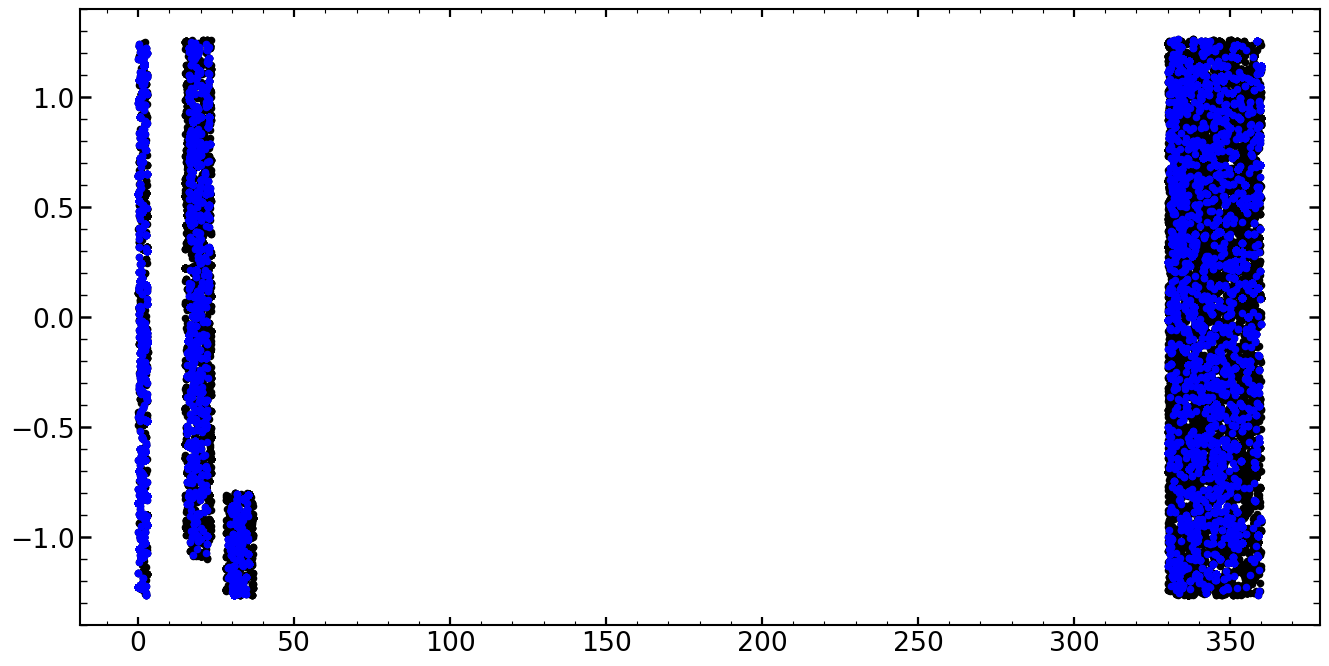

In [55]:
# check the overlap of two arrays
plt.figure(figsize=(16,8))
plt.scatter(Positions_of_matched_array_Stripe82_stars_to_dr7QSO[:,0],Positions_of_matched_array_Stripe82_stars_to_dr7QSO[:,1],color='black',s=20,label='HSC')
plt.scatter(Positions_of_df[:,0],Positions_of_df[:,1],color='blue',s=20,label='Stripe82')

plt.savefig(FIGURES_PDF_DIRECTORY + 'coverage_stars_Stripe_82_SDSS_HSC.pdf', bbox_inches='tight')
plt.savefig(FIGURES_PNG_DIRECTORY + 'coverage_stars_Stripe_82_SDSS_HSC.png', bbox_inches='tight')

In [56]:
# takes a bit less than 1 minute on my laptop
# this matches fake QSO from SDSS and resulting catalog from HSC
res_matching=[]
for j in tqdm(range(len(Positions_of_matched_array_Stripe82_stars_to_dr7QSO))):
    # finds distance from each of the objects in dr7 catalogue from the objects in HSC catalogue
    PositionOfQuasars_euclidean_distances=euclidean_distances([Positions_of_matched_array_Stripe82_stars_to_dr7QSO[j]],Positions_of_df)
    # shortest distance
    shortest_distance=np.min(PositionOfQuasars_euclidean_distances[0])
    # element of the ``Positions_of_df'' that has the shortest distance to the SDSS QSO
    shortest_distance_index=np.where(PositionOfQuasars_euclidean_distances[0]==np.min(PositionOfQuasars_euclidean_distances[0]))[0][0]
    res_matching.append([shortest_distance,df.loc[shortest_distance_index].values])

100%|██████████| 29595/29595 [00:14<00:00, 2067.04it/s]


In [167]:
# find all the stars which produced a hit in the HSC query
all_stars_found=[]
for i in range(len(datadr7_selection)):
    # for each QSO we selected 5 stars
    five_stars=[res_matching[i*5+0],res_matching[i*5+1],res_matching[i*5+2],res_matching[i*5+3],res_matching[i*5+4]]
    # this list contains how far away (in ra and dec) the closest star which was found in HSC is to the star that was input from SDSS
    five_distances=[five_stars[0][0],five_stars[1][0],five_stars[2][0],five_stars[3][0],five_stars[4][0]]
    for j in range(len(five_distances)):
        # if the distance is to big, the star from SDSS was not found in HSC - pass that object
        if five_distances[j]>0.001:
            pass
        # if the star was found add it to the ``all_stars_found'' array
        # if contains index, then ra dec, than ``redshift'', i.e., the redshift of the original QSO, SDSS measurments, HSC measurements
        else:
            all_stars_found.append(np.concatenate(([i],matched_array_Stripe82_stars_to_dr7QSO[i*5+j][[0,1]],[datadr7_selection[i][2]],\
                                                   matched_array_Stripe82_stars_to_dr7QSO[i*5+j][[2,3,4,5,6,7]],res_matching[i*5+j][1])))

           
all_stars_found=np.array(all_stars_found)  
# 0-th column contains the index of each found star, but it float - turn it in integer
all_stars_found[:,0]=all_stars_found[:,0].astype(int)

# index of QSO that found at least one star out of the 5 suggested stars
index_of_QSO_that_did_find_stars=(np.intersect1d(range(5919),np.unique(all_stars_found[:,0]))).astype(int)
# index of QSO that did not find any of the stars
index_of_QSO_that_did_not_find_stars=(np.setdiff1d(range(5919),np.unique(all_stars_found[:,0]))).astype(int)

In [60]:
# lets take invetory 
# if the QSO found at least one of the 5 stars suggested, than it is simple - just add it to array which wil contain all of the information
# this is case for majority of QSO
second_look_QSO_that_did_find_stars=[]
for l in index_of_QSO_that_did_find_stars:
    second_look_QSO_that_did_find_stars.append(all_stars_found[all_stars_found[:,0]==l][0])

# if there was not a hit for any of the 5 stars, find the closest stars out of the ones that have been found
second_look_QSO_that_did_not_find_stars=[]
for l in index_of_QSO_that_did_not_find_stars:
    # find distance in color space to the avaliable stars
    PositionOfQuasars_euclidean_distances_for_QSO_that_did_not_find=euclidean_distances([datadr7_selection[:,[3,5,7]][l]],all_stars_found[:,[4,6,8]],)
    # find the closest star
    shortest_distance=np.min(PositionOfQuasars_euclidean_distances_for_QSO_that_did_not_find)
    # find the index of the closest stars
    shortest_distance_index=np.where(PositionOfQuasars_euclidean_distances_for_QSO_that_did_not_find[0]==shortest_distance)[0][0]
    # use this star and append to the list
    second_look_QSO_that_did_not_find_stars.append(np.concatenate(([l],all_stars_found[shortest_distance_index][[1,2]],[datadr7_selection[l][2]],\
                                           all_stars_found[shortest_distance_index][4:])))

    

In [61]:
# join two lists (QSO that did find stars, and the QSO for which we had to have to do second look)
matched_array_fake_QSO_unsorted=np.concatenate((np.array(second_look_QSO_that_did_find_stars),np.array(second_look_QSO_that_did_not_find_stars)))
# sort according to the 0th column
matched_array_fake_QSO=matched_array_fake_QSO_unsorted[matched_array_fake_QSO_unsorted[:,0].argsort()]

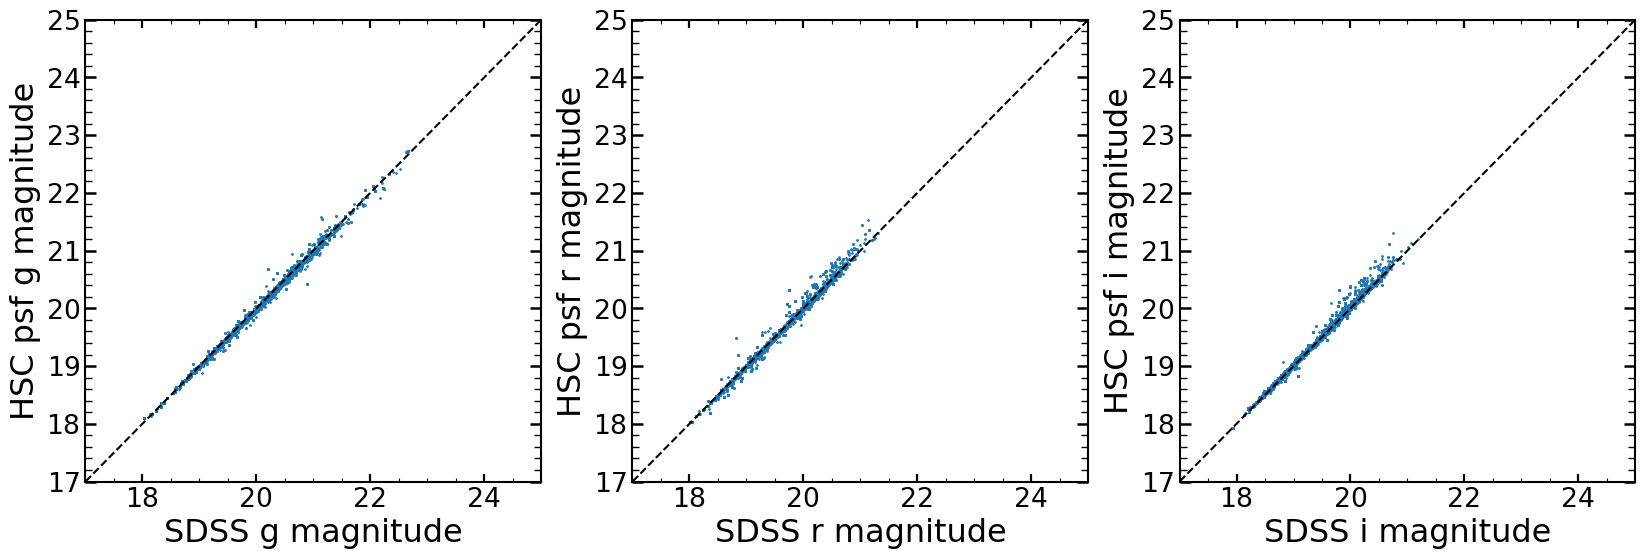

In [64]:
# plot differences between the measurments by using psf values from HSC
# note how much tighter this is compared to the QSO plot
plt.figure(figsize=(20,6))
plt.subplot(131)

plt.scatter(matched_array_fake_QSO[:,4],matched_array_fake_QSO[:,14+4],s=1)
plt.scatter(matched_array_fake_QSO[:,4][(matched_array_fake_QSO[:,14+4]-matched_array_fake_QSO[:,4])>1],
            matched_array_fake_QSO[:,14+4][(matched_array_fake_QSO[:,14+4]-matched_array_fake_QSO[:,4])>1],s=2)
plt.scatter(matched_array_fake_QSO[:,4][(matched_array_fake_QSO[:,14+4]-matched_array_fake_QSO[:,4])>2],
            matched_array_fake_QSO[:,14+4][(matched_array_fake_QSO[:,14+4]-matched_array_fake_QSO[:,4])>2],s=3,color='red')

plt.xlabel('SDSS g magnitude')
plt.ylabel('HSC psf g magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)

plt.subplot(132)

plt.scatter(matched_array_fake_QSO[:,6],matched_array_fake_QSO[:,14+6],s=1)
plt.scatter(matched_array_fake_QSO[:,6][(matched_array_fake_QSO[:,14+4]-matched_array_fake_QSO[:,4])>1],
            matched_array_fake_QSO[:,14+6][(matched_array_fake_QSO[:,14+4]-matched_array_fake_QSO[:,4])>1],s=2)
plt.scatter(matched_array_fake_QSO[:,6][(matched_array_fake_QSO[:,14+4]-matched_array_fake_QSO[:,4])>2],
            matched_array_fake_QSO[:,14+6][(matched_array_fake_QSO[:,14+4]-matched_array_fake_QSO[:,4])>2],s=3,color='red')
plt.xlabel('SDSS r magnitude')
plt.ylabel('HSC psf r magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)
plt.subplot(133)

plt.scatter(matched_array_fake_QSO[:,8],matched_array_fake_QSO[:,14+8],s=1)
plt.scatter(matched_array_fake_QSO[:,8][(matched_array_fake_QSO[:,14+4]-matched_array_fake_QSO[:,4])>1],
            matched_array_fake_QSO[:,14+8][(matched_array_fake_QSO[:,14+4]-matched_array_fake_QSO[:,4])>1],s=2)
plt.scatter(matched_array_fake_QSO[:,8][(matched_array_fake_QSO[:,14+4]-matched_array_fake_QSO[:,4])>2],
            matched_array_fake_QSO[:,14+8][(matched_array_fake_QSO[:,14+4]-matched_array_fake_QSO[:,4])>2],s=3,color='red')
plt.xlabel('SDSS i magnitude')
plt.ylabel('HSC psf i magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)

plt.savefig(FIGURES_PDF_DIRECTORY + 'comaprison_stars_SDSS_HSC_magnitudes.pdf', bbox_inches='tight')
plt.savefig(FIGURES_PNG_DIRECTORY + 'comaprison_stars_SDSS_HSC_magnitudes.png', bbox_inches='tight')

In [ ]:
# save the data
np.save(DATA_DIRECTORY+'matched_array_fake_QSO',matched_array_fake_QSO)

# Analysis of modelling results

In [14]:
# For modelling I ran the grid of simulations (see https://github.com/nevencaplar/AGN-Variability-Simulations)
# using the ``nominal script'' at https://github.com/nevencaplar/AGN-Variability-Simulations/blob/master/run_script_ex.sh
# and then varying 4 parameters in 7 steps
# So all together I ran 2401 simulations
# The grid of parameters is specified below

# frequency of the bend in the PSD broken power law
list_of_v_bend_in=10**np.linspace(-11,-8,7)
# position of the break in the Eddington ratio function
list_of_lambda_s_BPL_in=10**np.linspace(-2,0.0,7)
# high frequency (long times) slope of the PSD
list_of_a_low_in=[0.55,0.7,0.85,1.0,1.15,1.30,1.45]
# lower limit of the Eddington ratio distribution (smallest possible Eddington ratio)
list_of_LowerLimit_acc_in=10**np.linspace(-4.5,-2,7)




In [36]:
# this code creates summarizes results for each of the simulated lightcurves
# it takes ``list_of_single_LC_result'' files, which summarize statistical properties of eahc of the simulated lightcurves
# and gives reshift dependence, it the style seen on Figure 1,2,3 or 4, for each of these lightcurves

# When we do analysis below we will record the results at these timesteps
selection_of_times=np.unique((10**np.arange(0,5.5,0.1)).astype(int))
# which corresponds to these redshift, given that the mean time separation between surveys is 14.85 years
# and the cadence of recorded data points in the simulation was set at 100 days
selection_of_times_as_redshift_in_HSC_SDSS=(14.85*365.25)/(selection_of_times*100)-1


means_all_LC_redshift_list=[]
means_all_LC_redshift_fit_list=[]
means_all_LC_redshift_values_list=[]
for v_bend_index in tqdm(range(len(list_of_v_bend_in))):
    for lambda_s_BPL_index in range(len(list_of_lambda_s_BPL_in)):
        for a_low_index in range(len(list_of_a_low_in)):
            for LowerLimit_acc_index in range(len(list_of_LowerLimit_acc_in)):
                # structure of each list_of_single_LC_result file is 
                # starting Edd. ratio,standard deviation as function of time , mean change as function of time, median change as function of time
                # it is somewhat involved to get to these summary results from pure ligthcurves, and I do that on cluster i.e., it is outside the 
                # scope of this notebook
                # The code that create these files is avaliable in DATA_DIRECTORY+"Modelling/Code/", but without a lot of comments and it has
                # not be modified to run outside Princeton cluster
                single_LC_result = pickle.load( open(DATA_DIRECTORY+"Modelling/Analysis_results/list_of_single_LC_resultv_"+str(v_bend_index)+\
                                                     '_l_'+str(lambda_s_BPL_index)+'_a_'+str(a_low_index)+'_L_'+str(LowerLimit_acc_index)+".txt", "rb" ) )

                # 51 is the len of the selection of times
                means_single_LC=np.zeros((len(single_LC_result)*len(selection_of_times),7))
                means_single_LC_redshift=np.zeros((len(single_LC_result)*len(selection_of_times),7))
                
                # this part is so that you cut before you reach nan (if you reach nan, i.e., if there is not enough data for high Eddington ratios)
                means_Edd_index=[]
                for Edd_index in range(len(single_LC_result)):
                    means_Edd_index.append(np.mean(single_LC_result[Edd_index][0]))
                    
                if np.sum(np.isnan(means_Edd_index))==0:
                    len_of_single_LC_result_analysis=len(single_LC_result)
                else:
                    len_of_single_LC_result_analysis=np.argwhere(np.isnan(means_Edd_index))[0][0]-1
                
                
                for Edd_index in range(len_of_single_LC_result_analysis):
                    # createa array which explicity connects time with results for each prameter
                    means_single_LC_single_Edd_redshift=np.array([np.full(len(selection_of_times),list_of_v_bend_in[v_bend_index]),\
                                                                  np.full(len(selection_of_times),list_of_lambda_s_BPL_in[lambda_s_BPL_index]),\
                                                                  np.full(len(selection_of_times),list_of_a_low_in[a_low_index]),\
                                                                  np.full(len(selection_of_times),list_of_LowerLimit_acc_in[LowerLimit_acc_index]),\
                                                                  single_LC_result[Edd_index][0],selection_of_times_as_redshift_in_HSC_SDSS,\
                                                                  single_LC_result[Edd_index][2][:,0]])
                    # move the results to redshift space
                    means_single_LC_redshift[Edd_index*len(selection_of_times):(Edd_index+1)*len(selection_of_times)]=np.transpose(means_single_LC_single_Edd_redshift)
                    # cut results to only include data between redshift 0 and 4, mimicking the real dta
                    means_single_LC_single_Edd_redshift_transpose=np.transpose(means_single_LC_single_Edd_redshift)
                    means_single_LC_single_Edd_redshift_0_4_transpose=means_single_LC_single_Edd_redshift_transpose\
                    [(means_single_LC_single_Edd_redshift_transpose[:,-2]>0)&(means_single_LC_single_Edd_redshift_transpose[:,-2]<4)]
                    # create redshift fit to the data
                    z=np.polyfit(means_single_LC_single_Edd_redshift_0_4_transpose[:,-2],means_single_LC_single_Edd_redshift_0_4_transpose[:,-1],2)
                    
                    # put the results of the fit for all of the simulations in the list
                    # so this list has all of the parameters (frequency break, Edd. ratio break, low-slope of PSD, lower limit of Edd. ratio distribution)
                    # starting value of the Eddington ratio + 3 values for the second order fit in the redshift domain
                    means_all_LC_redshift_fit_list.append([list_of_v_bend_in[v_bend_index],list_of_lambda_s_BPL_in[lambda_s_BPL_index],\
                                                          list_of_a_low_in[a_low_index],list_of_LowerLimit_acc_in[LowerLimit_acc_index],
                                                          np.round(single_LC_result[Edd_index][0][0],2),z[0],z[1],z[2]])
                    # put the individual points for all of the simulations in the list
                    # so this list has all of the parameters (frequency break, Edd. ratio break, low-slope of PSD, lower limit of Edd. ratio distribution)
                    # starting value of the Eddington ratio + values for 7 individual points specified in selection_of_times_as_redshift_in_HSC_SDSS
                    # which are between redshift 0 and 4
                    
                    means_all_LC_redshift_values_list.append([list_of_v_bend_in[v_bend_index],list_of_lambda_s_BPL_in[lambda_s_BPL_index],\
                                                          list_of_a_low_in[a_low_index],list_of_LowerLimit_acc_in[LowerLimit_acc_index],
                                                          np.round(single_LC_result[Edd_index][0][0],2),means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][0]\
                                                             ,means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][1],means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][2]\
                                                             ,means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][3],means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][4]\
                                                             ,means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][5],means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][6]])
                    
                    
# as explained above, the results havee the shape
# v_bend, lamda*, alpha_low, lower_limit, Edd_limit, z0,z1,z2  (z0,z1,z2 are values for the second order fit in the redshift space)                 
means_all_LC_redshift_fit=np.array(means_all_LC_redshift_fit_list)

 # v_bend, lamda*, alpha_low, lower_limit, Edd_limit, 7 redshift values                
means_all_LC_redshift_values=np.array(means_all_LC_redshift_values_list)

100%|██████████| 7/7 [00:24<00:00,  3.53s/it]


In [17]:
# save the data
np.save(DATA_DIRECTORY+'means_all_LC_redshift_fit',means_all_LC_redshift_fit)
np.save(DATA_DIRECTORY+'means_all_LC_redshift_values',means_all_LC_redshift_values)

# Figure 1 from the paper (redshift dependence)

In [174]:
# load the master array having all information created in the previous section
matched_array_filtered=np.load(DATA_DIRECTORY+'matched_array_filtered.npy') 

In [175]:
# g-band
# This function (create_redshift_result) creates the main result
#
# Inputs are:
# matched_array_filtered - array contaning magnitudes
# 100 - number of QSO in each redshift bin
# sdss_band_column=4 - in which column of matched_array_filtered are g-band SDSS magnitudes stored (4 for g-band, 6 for r-band and 8 for i band)
# difference_sdss_HSC_columns=14 - offset to column in which g-band pfs HSC magnitudes are stored (8 to match with c-model magnitudes from HSC, 14 to match with psf)
# return_median_mag_values = True - should the function return mediam magnitudes in each redshift bin
#
# Outputs:
# res_delta_redshift_via_redshift_array_g - mean difference in magnitude as a function of redshift
# res_delta_redshift_via_redshift_median_array_g - median difference in magnitude as a function of redshift
# res_delta_redshift_via_redshift_err_array_g - error on the mean difference in magnitude as a function of redshift
# res_delta_redshift_via_redshift_median_err_array_g - error on the median difference in magnitude as a function of redshift
# res_redshift_array_g - redshift at which point are evaluated
# p20_array_g - second order fit to the mean difference
# p20_median_array_g - second order fit to the median difference
# median_mag_values_array_g - median magnitudes values at each redshift

res_delta_redshift_via_redshift_array_g,res_delta_redshift_via_redshift_median_array_g,\
res_delta_redshift_via_redshift_err_array_g,res_delta_redshift_via_redshift_median_err_array_g,\
res_redshift_array_g,p20_array_g,p20_median_array_g,median_mag_values_array_g=\
create_redshift_result(matched_array_filtered,100,sdss_band_column=4,difference_sdss_HSC_columns=14,return_median_mag_values=True)


# Here we repeat the fitting part of the algotithm as the p20 function in the master function above does not give error on the fit
# This is because I only later realized that we have to also compute errors on the fit (sic!)
# So we repeat the analysis, and we do a linear fit
p20_array_g=[]
# there are 6 subarrays in the results
# index 0 is for whole dataset
# index 1-5 refers to the dataset separated by luminosity
for i in range(6):
    res_redshift_array_single_g=res_redshift_array_g[i]
    res_delta_redshift_via_redshift_array_single_g=res_delta_redshift_via_redshift_array_g[i]
    res_delta_redshift_via_redshift_err_array_single_g=res_delta_redshift_via_redshift_err_array_g[i]   
    
    if i==0:
        create_p20_values(res_redshift_array_single_g,res_delta_redshift_via_redshift_array_single_g,res_delta_redshift_via_redshift_err_array_single_g,False,True)  
    p20_array_g.append(create_p20_values(res_redshift_array_single_g,res_delta_redshift_via_redshift_array_single_g,res_delta_redshift_via_redshift_err_array_single_g))

# exactly the same, but fitting as a function of restframe time that has passed between observations
p20_array_g_time=[]
for i in range(6):
    res_redshift_array_single_g=res_redshift_array_g[i]
    res_delta_redshift_via_redshift_array_single_g=res_delta_redshift_via_redshift_array_g[i]
    res_delta_redshift_via_redshift_err_array_single_g=res_delta_redshift_via_redshift_err_array_g[i]   
        
    p20_array_g_time.append(create_p20_values(res_redshift_array_single_g,\
                                              res_delta_redshift_via_redshift_array_single_g,res_delta_redshift_via_redshift_err_array_single_g,time_result=True))       

redshift fit  
0.05285 x - 0.1843
time fit  
-0.02327 x + 0.04454


In [176]:
# same thing for r-band
res_delta_redshift_via_redshift_array_r,res_delta_redshift_via_redshift_median_array_r,\
res_delta_redshift_via_redshift_err_array_r,res_delta_redshift_via_redshift_median_err_array_r,\
res_redshift_array_r,p20_array_r,p20_median_array_r,median_mag_values_array_r=\
create_redshift_result(matched_array_filtered,100,sdss_band_column=6,difference_sdss_HSC_columns=14,return_median_mag_values=True)

p20_array_r=[]
for i in range(6):
    res_redshift_array_single_r=res_redshift_array_r[i]
    res_delta_redshift_via_redshift_array_single_r=res_delta_redshift_via_redshift_array_r[i]
    res_delta_redshift_via_redshift_err_array_single_r=res_delta_redshift_via_redshift_err_array_r[i]   
        
    p20_array_r.append(create_p20_values(res_redshift_array_single_r,res_delta_redshift_via_redshift_array_single_r,res_delta_redshift_via_redshift_err_array_single_r))
    
p20_array_r_time=[]
for i in range(6):
    res_redshift_array_single_r=res_redshift_array_r[i]
    res_delta_redshift_via_redshift_array_single_r=res_delta_redshift_via_redshift_array_r[i]
    res_delta_redshift_via_redshift_err_array_single_r=res_delta_redshift_via_redshift_err_array_r[i]   
        
    p20_array_r_time.append(create_p20_values(res_redshift_array_single_r,\
                                         res_delta_redshift_via_redshift_array_single_r,res_delta_redshift_via_redshift_err_array_single_r,time_result=True))    

In [177]:
# same thing for i-band
res_delta_redshift_via_redshift_array_i,res_delta_redshift_via_redshift_median_array_i,\
res_delta_redshift_via_redshift_err_array_i,res_delta_redshift_via_redshift_median_err_array_i,\
res_redshift_array_i,p20_array_i,p20_median_array_i,median_mag_values_array_i=\
create_redshift_result(matched_array_filtered,100,sdss_band_column=8,difference_sdss_HSC_columns=14,return_median_mag_values=True)

p20_array_i=[]
for i in range(6):
    res_redshift_array_single_i=res_redshift_array_i[i]
    res_delta_redshift_via_redshift_array_single_i=res_delta_redshift_via_redshift_array_i[i]
    res_delta_redshift_via_redshift_err_array_single_i=res_delta_redshift_via_redshift_err_array_i[i]   
        
    p20_array_i.append(create_p20_values(res_redshift_array_single_i,res_delta_redshift_via_redshift_array_single_i,res_delta_redshift_via_redshift_err_array_single_i))
    
p20_array_i_time=[]
for i in range(6):
    res_redshift_array_single_i=res_redshift_array_i[i]
    res_delta_redshift_via_redshift_array_single_i=res_delta_redshift_via_redshift_array_i[i]
    res_delta_redshift_via_redshift_err_array_single_i=res_delta_redshift_via_redshift_err_array_i[i]   
        
    p20_array_i_time.append(create_p20_values(res_redshift_array_single_i,\
                                         res_delta_redshift_via_redshift_array_single_i,res_delta_redshift_via_redshift_err_array_single_i,time_result=True))    

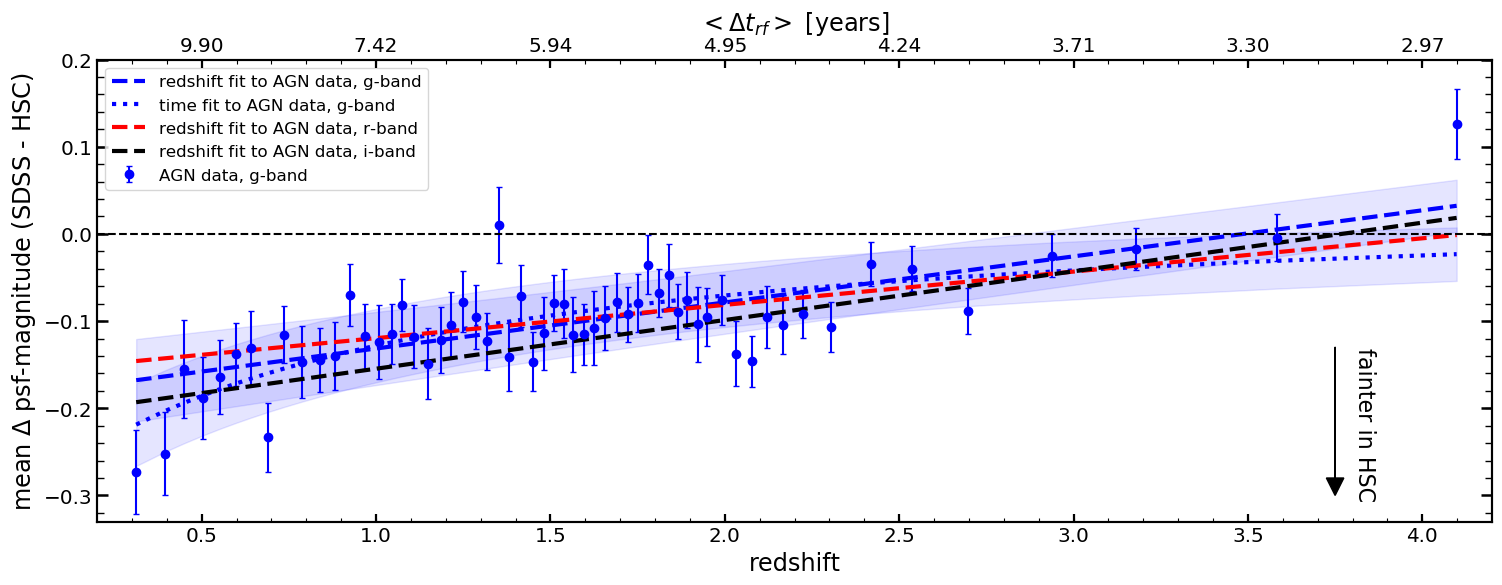

In [178]:
matplotlib.rcParams.update({'font.size': 12})
fig=plt.figure(figsize=(18,6))

ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

# datapoints

## g-band
### mean
ax1.errorbar(res_redshift_array_g[0],res_delta_redshift_via_redshift_array_g[0],yerr=res_delta_redshift_via_redshift_err_array_g[0],\
             marker='o',capsize=2,ls='',color='blue',label='AGN data, g-band')
### median
#ax1.errorbar(res_redshift_array_g[0],res_delta_redshift_via_redshift_median_array_g[0],yerr=res_delta_redshift_via_redshift_median_err_array_g[0],\
#             marker='o',capsize=2,ls='',color='cyan',label='AGN data, g-band')

## r-band
### mean
#ax1.errorbar(res_redshift_array_r[0],res_delta_redshift_via_redshift_array_r[0],yerr=res_delta_redshift_via_redshift_err_array_r[0],\
#marker='o',capsize=2,ls='',color='blue',label='AGN data, r-band')
### median
#ax1.errorbar(res_redshift_array_r[0],res_delta_redshift_via_redshift_median_array_r[0],yerr=res_delta_redshift_via_redshift_median_err_array_r[0],\
#marker='o',capsize=2,ls='',color='blue',label='AGN data, r-band')

## i-band
### mean
#ax1.errorbar(res_redshift_array_i[0],res_delta_redshift_via_redshift_array_i[0],yerr=res_delta_redshift_via_redshift_err_array_i[0],\
#marker='o',capsize=2,ls='',color='blue',label='AGN data, i-band')
### median
##ax1.errorbar(res_redshift_array_i[0],res_delta_redshift_via_redshift_array_i[0],yerr=res_delta_redshift_via_redshift_err_array_i[0],\
#marker='o',capsize=2,ls='',color='blue',label='AGN data, g-band')


# g-band fit
## redshift fit
ax1.plot(res_redshift_array_g[0],p20_array_g[0][0],ls='--',color='blue',lw=3,label='redshift fit to AGN data, g-band')
ax1.fill_between(res_redshift_array_g[0], p20_array_g[0][2],p20_array_g[0][1], color='blue', alpha='0.1')

## time fit
ax1.plot(res_redshift_array_g[0],p20_array_g_time[0][0],ls=':',color='blue',lw=3,label='time fit to AGN data, g-band')
ax1.fill_between(res_redshift_array_g[0], p20_array_g_time[0][2],p20_array_g_time[0][1], color='blue', alpha='0.1')


# r-band fit
## redshift fit
ax1.plot(res_redshift_array_r[0],p20_array_r[0][0],ls='--',color='red',lw=3,label= 'redshift fit to AGN data, r-band')
ax1.fill_between(res_redshift_array_r[0], p20_array_r[0][2],p20_array_r[0][1], color='red', alpha='0.0')

## time fit
#ax1.plot(res_redshift_array_r[0],p20_array_r_time[0][0],ls=':',color='red',lw=3,label='time fit to QSO data, r-band')
#ax1.fill_between(res_redshift_array_r[0], p20_array_r_time[0][2],p20_array_r_time[0][1], color='red', alpha='0.0')

# i-band fit
## redshift fit
ax1.plot(res_redshift_array_i[0],p20_array_i[0][0],ls='--',color='black',lw=3,label='redshift fit to AGN data, i-band')
ax1.fill_between(res_redshift_array_i[0], p20_array_i[0][2],p20_array_i[0][1], color='black', alpha='0.0')

## time fit
#ax1.plot(res_redshift_array_i[0],p20_array_i_time[0][0],ls=':',color='black',lw=3,label='time fit to QSO data, i-band')
#ax1.fill_between(res_redshift_array_i[0], p20_array_i_time[0][2],p20_array_i_time[0][1], color='black', alpha='0.0')


ax1.arrow(3.75,-0.13,-0.,-0.15,head_length=0.02,head_width=0.05,color='black')
ax1.text(3.8,-0.15,'fainter in HSC',rotation=270,size=16)

ax2Xs = ax1.get_xticks()
ax2.set_xticks(ax2Xs)
ax2.set_xticklabels(['',"%.2f" % round(14.85/(1+0.5),2) ,"%.2f" % round(14.85/(1+1),2),"%.2f" % round(14.85/(1+1.5),2),\
                     "%.2f" % round(14.85/(1+2),2),"%.2f" % round(14.85/(1+2.5),2),"%.2f" % round(14.85/(1+3),2),\
                     "%.2f" % round(14.85/(1+3.5),2),"%.2f" % round(14.85/(1+4),2)])
ax2.set_xlim(0.2,4.2)
ax2.set_xlabel('$<\Delta t_{rf}>$ [years]')


ax1.set_ylabel('mean $\Delta$ psf-magnitude (SDSS - HSC)')
ax1.set_xlabel('redshift')
ax1.set_ylim(-0.33,0.2)
ax1.set_xlim(0.2,4.2)
ax1.axhline(0,color='black',ls='--')
ax1.legend()

plt.savefig(FIGURES_PDF_DIRECTORY + 'Figure1_redshift_effect.pdf', bbox_inches='tight')
plt.savefig(FIGURES_PNG_DIRECTORY + 'Figure1_redshift_effect.png', bbox_inches='tight')

# Figure 2 from the paper (filter and control sample)

In [179]:
# we proceed as in the previous section. First we do the standard analysis

matched_array_filtered=np.load(DATA_DIRECTORY+'matched_array_filtered.npy') 

res_delta_redshift_via_redshift_array_g,res_delta_redshift_via_redshift_median_array_g,\
res_delta_redshift_via_redshift_err_array_g,res_delta_redshift_via_redshift_median_err_array_g,\
res_redshift_array_g,p20_array_g,p20_median_array_g,median_mag_values_array_g=\
create_redshift_result(matched_array_filtered,100,sdss_band_column=4,difference_sdss_HSC_columns=14,return_median_mag_values=True)


p20_array_g=[]
for i in range(6):
    res_redshift_array_single_g=res_redshift_array_g[i]
    res_delta_redshift_via_redshift_array_single_g=res_delta_redshift_via_redshift_array_g[i]
    res_delta_redshift_via_redshift_err_array_single_g=res_delta_redshift_via_redshift_err_array_g[i]   
        
    p20_array_g.append(create_p20_values(res_redshift_array_single_g,res_delta_redshift_via_redshift_array_single_g,res_delta_redshift_via_redshift_err_array_single_g))


In [180]:
# We do the same analysis with our ``fake sample''
matched_array_fake_QSO=np.load(DATA_DIRECTORY+'matched_array_fake_QSO.npy')
# we verify that this sample also contains 5919 objects
print(len(matched_array_fake_QSO))

res_delta_redshift_via_redshift_fake_QSO_array_g,res_delta_redshift_via_redshift_median_fake_QSO_array_g,\
res_delta_redshift_via_redshift_fake_QSO_err_array_g,res_delta_redshift_via_redshift_median_fake_QSO_err_array_g,\
res_redshift_fake_QSO_array_g,p20_fake_QSO_array_g,p20_median_fake_QSO_array_g=\
create_redshift_result(matched_array_fake_QSO,100,sdss_band_column=4,difference_sdss_HSC_columns=14)

p20_fake_QSO_array_g=[]
for i in range(6):
    res_redshift_array_fake_QSO_single_g=res_redshift_fake_QSO_array_g[i]
    res_delta_redshift_via_redshift_fake_QSO_array_single_g=res_delta_redshift_via_redshift_fake_QSO_array_g[i]
    res_delta_redshift_via_redshift_fake_QSO_err_array_single_g=res_delta_redshift_via_redshift_fake_QSO_err_array_g[i]   
        
    p20_fake_QSO_array_g.append(create_p20_values(res_redshift_array_fake_QSO_single_g,res_delta_redshift_via_redshift_fake_QSO_array_single_g,\
                                                  res_delta_redshift_via_redshift_fake_QSO_err_array_single_g))

5919


In [181]:
# Here we load filter redshift curves
# we make avaliable calucations with two different AGN templates
from astropy.table import Table

HSC_SDSS_filter_redshift_dependence=Table.read(DATA_DIRECTORY+'dmag_HSC_SDSS_AGN_quasar.fits')
HSC_SDSS_filter_redshift_dependence_redshift=HSC_SDSS_filter_redshift_dependence['redshift'].data

HSC_SDSS_filter_redshift_dependence_dg=HSC_SDSS_filter_redshift_dependence['dg_AGN'].data
HSC_SDSS_filter_redshift_dependence_dr=HSC_SDSS_filter_redshift_dependence['dr_AGN'].data
HSC_SDSS_filter_redshift_dependence_di=HSC_SDSS_filter_redshift_dependence['di_AGN'].data

HSC_SDSS_filter_redshift_dependence_dg_Vandenberk=HSC_SDSS_filter_redshift_dependence['dg_quasar'].data
HSC_SDSS_filter_redshift_dependence_dr_Vandenberk=HSC_SDSS_filter_redshift_dependence['dr_quasar'].data
HSC_SDSS_filter_redshift_dependence_di_Vandenberk=HSC_SDSS_filter_redshift_dependence['di_quasar'].data

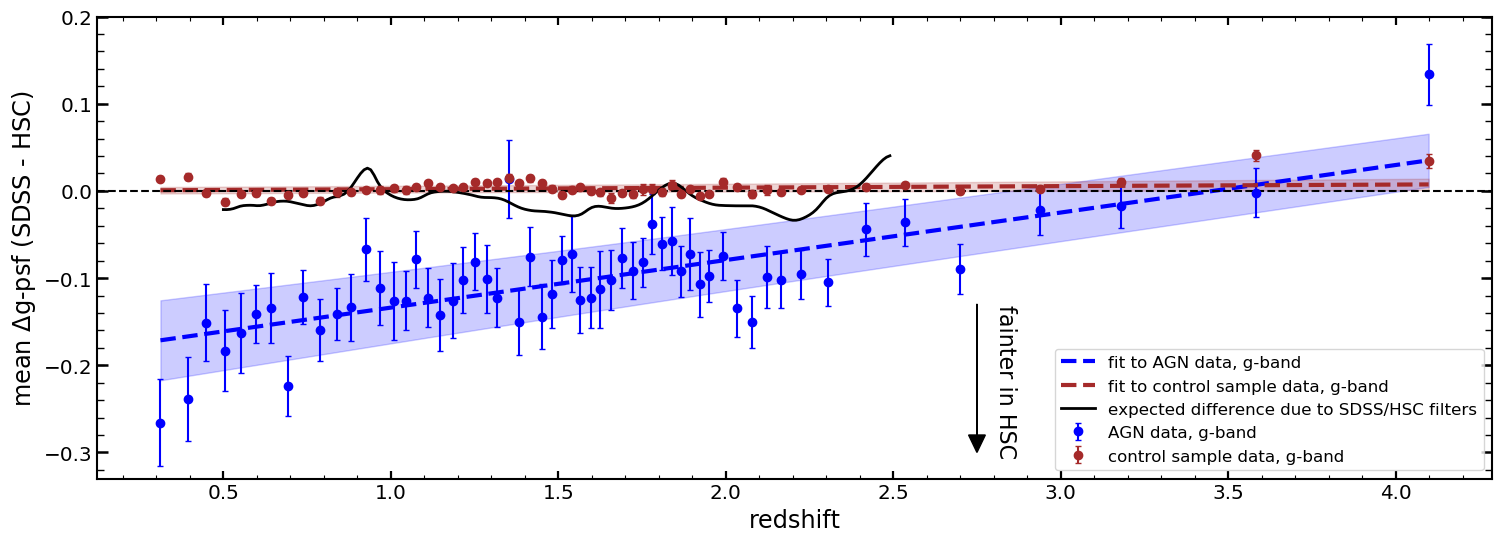

In [182]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))

# data points for the QSO data
plt.errorbar(res_redshift_array_g[0],res_delta_redshift_via_redshift_array_g[0],yerr=res_delta_redshift_via_redshift_err_array_g[0],\
             marker='o',capsize=2,ls='',color='blue',label='AGN data, g-band')
# data points for the nonvariable stars data
plt.errorbar(res_redshift_fake_QSO_array_g[0],res_delta_redshift_via_redshift_fake_QSO_array_g[0],yerr=res_delta_redshift_via_redshift_fake_QSO_err_array_g[0],\
             marker='o',capsize=2,ls='',color='brown',label='control sample data, g-band')

# fit and the prediction band for the QSO data
plt.plot(res_redshift_array_g[0],p20_array_g[0][0],ls='--',color='blue',lw=3,label='fit to AGN data, g-band')
plt.fill_between(res_redshift_array_g[0], p20_array_g[0][2],p20_array_g[0][1], color='blue', alpha='0.2')

# fit and the prediciton band for the nonvariable stars data
plt.plot(res_redshift_fake_QSO_array_g[0],p20_fake_QSO_array_g[0][0],ls='--',color='brown',lw=3,label='fit to control sample data, g-band')
plt.fill_between(res_redshift_fake_QSO_array_g[0], p20_fake_QSO_array_g[0][2],p20_fake_QSO_array_g[0][1],\
                 color='brown', alpha='0.2')

# filter difference between SDSS and HSC
plt.plot(HSC_SDSS_filter_redshift_dependence_redshift,-HSC_SDSS_filter_redshift_dependence_dg_Vandenberk,\
         ls='-',color='black',lw=2,label='expected difference due to SDSS/HSC filters')

plt.arrow(2.75,-0.13,-0.,-0.15,head_length=0.02,head_width=0.05,color='black')
plt.text(2.8,-0.15,'fainter in HSC',rotation=270,size=16)

plt.ylabel('mean $\Delta$g-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.33,0.2)
plt.axhline(0,color='black',ls='--')
plt.legend()

plt.savefig(FIGURES_PDF_DIRECTORY + 'Figure2_filter_and_control_sample.pdf', bbox_inches='tight')
plt.savefig(FIGURES_PNG_DIRECTORY + 'Figure2_filter_and_control_sample.png', bbox_inches='tight')

# Figure 3 from the paper (brightness separation)

In [185]:
# We proceed as in the previous section. First we do the standard analysis

matched_array_filtered=np.load(DATA_DIRECTORY+'matched_array_filtered.npy') 

res_delta_redshift_via_redshift_array_g,res_delta_redshift_via_redshift_median_array_g,\
res_delta_redshift_via_redshift_err_array_g,res_delta_redshift_via_redshift_median_err_array_g,\
res_redshift_array_g,p20_array_g,p20_median_array_g,median_mag_values_array_g=\
create_redshift_result(matched_array_filtered,100,sdss_band_column=4,difference_sdss_HSC_columns=14,return_median_mag_values=True)


p20_array_g=[]
for i in range(6):
    res_redshift_array_single_g=res_redshift_array_g[i]
    res_delta_redshift_via_redshift_array_single_g=res_delta_redshift_via_redshift_array_g[i]
    res_delta_redshift_via_redshift_err_array_single_g=res_delta_redshift_via_redshift_err_array_g[i]   
        
    p20_array_g.append(create_p20_values(res_redshift_array_single_g,res_delta_redshift_via_redshift_array_single_g,res_delta_redshift_via_redshift_err_array_single_g))

    
# Here we calculate mean error of the fit to the different brightness bins
upper_limit_many=[]
lower_limit_many=[]
for i in range(1,6):
    lower_limit_single=-np.abs(p20_array_g[i][0]-p20_array_g[i][2])
    upper_limit_single=np.abs((p20_array_g[i][1]-p20_array_g[i][0]))
    upper_limit_many.append(upper_limit_single)
    lower_limit_many.append(lower_limit_single)

upper_limit_many_mean=np.mean(np.array(upper_limit_many),axis=0)
lower_limit_many_mean=np.mean(np.array(lower_limit_many),axis=0)

mean_err_single_point=np.mean([np.mean(res_delta_redshift_via_redshift_err_array_g[1]),np.mean(res_delta_redshift_via_redshift_err_array_g[2]),\
        np.mean(res_delta_redshift_via_redshift_err_array_g[3]),np.mean(res_delta_redshift_via_redshift_err_array_g[4]),\
       np.mean(res_delta_redshift_via_redshift_err_array_g[5])])

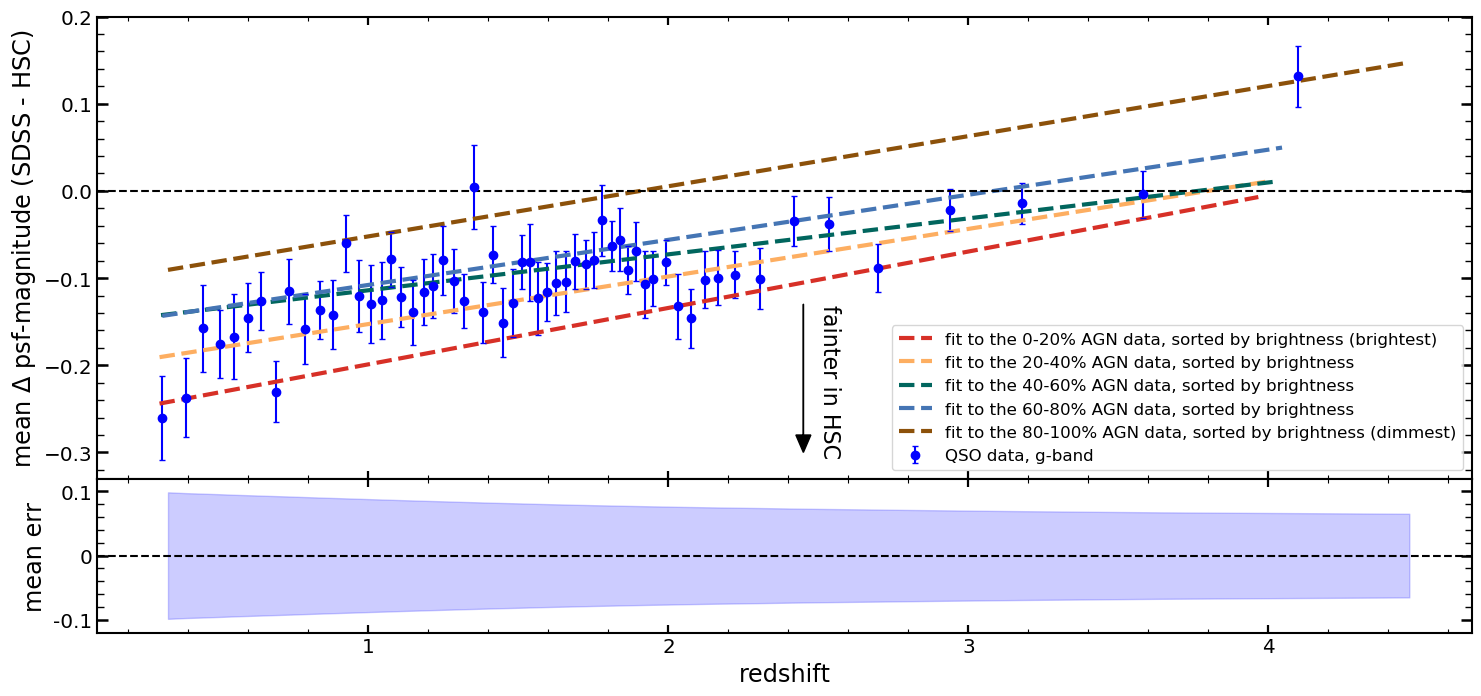

In [186]:

fig = plt.figure(figsize=(24, 8))
# Set up the axes with gridspec
grid = plt.GridSpec(4, 4, hspace=0., wspace=0.2)
# Set up main panel
main_ax = fig.add_subplot(grid[:-1, 1:])
# Set up smaller panel which contains uncertainty
err_ax = fig.add_subplot(grid[-1, 1:], yticklabels=[-0.1,0,0.1], sharex=main_ax)

# fit to all bands
main_ax.plot(res_redshift_array_g[1],p20_array_g[1][0],ls='--',color='#d73027',alpha=1,lw=3,
             label='fit to the 0-20% AGN data, sorted by brightness (brightest)')
main_ax.plot(res_redshift_array_g[2],p20_array_g[2][0],ls='--',color='#fdae61',alpha=1,lw=3,
             label='fit to the 20-40% AGN data, sorted by brightness')
main_ax.plot(res_redshift_array_g[3],p20_array_g[3][0],ls='--',color='#01665e',alpha=1,lw=3,
             label='fit to the 40-60% AGN data, sorted by brightness')
main_ax.plot(res_redshift_array_g[4],p20_array_g[4][0],ls='--',color='#4575b4',alpha=1,lw=3,
             label='fit to the 60-80% AGN data, sorted by brightness')
main_ax.plot(res_redshift_array_g[5],p20_array_g[5][0],ls='--',color='#8c510a',alpha=1,lw=3,
             label='fit to the 80-100% AGN data, sorted by brightness (dimmest)')


# uncomment to see individual datapoints

#main_ax.errorbar(res_redshift_array_g[1],res_delta_redshift_via_redshift_array_g[1],yerr=res_delta_redshift_via_redshift_err_array_g[1],\
#             marker='o',capsize=2,ls='',color='#d73027',label='0-20% AGN data, sorted by brightness')
#main_ax.errorbar(res_redshift_array_g[2],res_delta_redshift_via_redshift_array_g[2],yerr=res_delta_redshift_via_redshift_err_array_g[2],\
#             marker='o',capsize=2,ls='',color='#fdae61',label='20-40% AGN data, sorted by brightness')
#main_ax.errorbar(res_redshift_array_g[3],res_delta_redshift_via_redshift_array_g[3],yerr=res_delta_redshift_via_redshift_err_array_g[3],\
#             marker='o',capsize=2,ls='',color='#01665e',label='40-60% AGN data, sorted by brightness')
#main_ax.errorbar(res_redshift_array_g[4],res_delta_redshift_via_redshift_array_g[4],yerr=res_delta_redshift_via_redshift_err_array_g[4],\
#             marker='o',capsize=2,ls='',color='#4575b4',label='60-80% AGN data, sorted by brightness')
#main_ax.errorbar(res_redshift_array_g[5],res_delta_redshift_via_redshift_array_g[5],yerr=res_delta_redshift_via_redshift_err_array_g[5],\
#             marker='o',capsize=2,ls='',color='#8c510a',label='80-100% AGN data, sorted by brightness (dimmest)')

# uncomment in order to see uncertainty bands on the main plot

#main_ax.fill_between(res_redshift_array_g[1],p20_array_g[1][2],p20_array_g[1][1], color='#d73027', alpha='0.2')
#main_ax.fill_between(res_redshift_array_g[2],p20_array_g[2][2],p20_array_g[2][1], color='#fdae61', alpha='0.2')
#main_ax.fill_between(res_redshift_array_g[3],p20_array_g[3][2],p20_array_g[3][1], color='#01665e', alpha='0.2')
#main_ax.fill_between(res_redshift_array_g[4],p20_array_g[4][2],p20_array_g[4][1], color='#4575b4', alpha='0.2')
#main_ax.fill_between(res_redshift_array_g[5],p20_array_g[5][2],p20_array_g[5][1], color='#8c510a', alpha='0.2')

# data for the whole dataset
main_ax.errorbar(res_redshift_array_g[0],res_delta_redshift_via_redshift_array_g[0],yerr=res_delta_redshift_via_redshift_err_array_g[0],\
                 marker='o',capsize=2,ls='',color='blue',label='QSO data, g-band')

main_ax.set_ylabel('mean $\Delta$ psf-magnitude (SDSS - HSC)')
main_ax.set_xlabel('redshift')
main_ax.set_ylim(-0.33,0.2)
main_ax.axhline(0,color='black',ls='--')
main_ax.legend()

main_ax.arrow(2.45,-0.13,-0.,-0.15,head_length=0.02,head_width=0.05,color='black')
main_ax.text(2.5,-0.15,'fainter in HSC',rotation=270,size=16)

# smaller plot showing prediction bands
err_ax.fill_between(res_redshift_array_g[5],lower_limit_many_mean,upper_limit_many_mean, color='blue', alpha='0.2')

# individual prediction bands
# you can see that more luminous objects have somewhat smaller uncertanies, as expected given that AGN variability decreases as luminosity increses

#err_ax.plot(res_redshift_array_g[1],-np.abs(p20_array_g[1][0]-p20_array_g[1][2]), color='#d73027',ls='--')
#err_ax.plot(res_redshift_array_g[1],np.abs(p20_array_g[1][1]-p20_array_g[1][0]), color='#d73027', ls='--')
#err_ax.plot(res_redshift_array_g[2],-np.abs(p20_array_g[2][0]-p20_array_g[2][2]), color='#fdae61',ls='--')
#err_ax.plot(res_redshift_array_g[2],np.abs(p20_array_g[2][1]-p20_array_g[2][0]), color='#fdae61', ls='--')
#err_ax.plot(res_redshift_array_g[3],-np.abs(p20_array_g[3][0]-p20_array_g[3][2]), color='#01665e',ls='--')
#err_ax.plot(res_redshift_array_g[3],np.abs(p20_array_g[3][1]-p20_array_g[3][0]), color='#01665e', ls='--')
#err_ax.plot(res_redshift_array_g[4],-np.abs(p20_array_g[4][0]-p20_array_g[4][2]), color='#4575b4',ls='--')
#err_ax.plot(res_redshift_array_g[4],np.abs(p20_array_g[4][1]-p20_array_g[4][0]), color='#4575b4', ls='--')
#err_ax.plot(res_redshift_array_g[5],-np.abs(p20_array_g[5][0]-p20_array_g[5][2]), color='#8c510a',ls='--')
#err_ax.plot(res_redshift_array_g[5],np.abs(p20_array_g[5][1]-p20_array_g[5][0]), color='#8c510a', ls='--')

err_ax.set_ylim(-0.12,0.12)
err_ax.set_yticks([-0.1,0,0.1])
err_ax.axhline(0,color='black',ls='--')
err_ax.set_ylabel('mean err')
err_ax.set_xlabel('redshift')

plt.savefig(FIGURES_PDF_DIRECTORY + 'Figure3_brightness_separated.pdf', bbox_inches='tight')
plt.savefig(FIGURES_PNG_DIRECTORY + 'Figure3_brightness_separated.png', bbox_inches='tight')

# Figure 4 from the paper (time separation)

In [187]:
# first we load the data
# we load the ``normal'' array contaning all the magnitudes
matched_array_filtered=np.load(DATA_DIRECTORY+'matched_array_filtered.npy') 
# we also load the arrayt contaning information about time separation for each object
time_difference_between_observations_in_g_band_SDSS_mean_HSC=np.load(DATA_DIRECTORY+'time_difference_between_observations_in_g_band_SDSS_mean_HSC.npy')

In [188]:
# this is basically the same function as before but it also gives separate result for the AGN which are in the lowest quantile
# according to the time separation between two measurments and for the AGN which are in the highest quantile
res_redshift_all_short_long=create_redshift_result(matched_array_filtered,250,sdss_band_column=4,difference_sdss_HSC_columns=14,\
                                                   return_median_mag_values=True,separate_in_time_dif=True,\
                                                   time_dif_array=time_difference_between_observations_in_g_band_SDSS_mean_HSC)

In [189]:
# we assign result from the full sample
# these are contained in the 0-th element of res_redshift_all_short_long
res_delta_redshift_via_redshift_array,res_delta_redshift_via_redshift_median_array,\
res_delta_redshift_via_redshift_err_array,res_delta_redshift_via_redshift_median_err_array,\
res_redshift_array,p20_array,p20_median_array,median_mag_values_array=res_redshift_all_short_long[0]

# we assign result from the short separation sample
# these are contained in the 1st element of res_redshift_all_short_long
res_delta_redshift_via_redshift_short_separations_array,res_delta_redshift_via_redshift_median_short_separations_array,\
res_delta_redshift_via_redshift_err_short_separations_array,res_delta_redshift_via_redshift_median_err_short_separations_array,\
res_redshift_short_separations_array,p20_short_separations_array,p20_median_short_separations_array,median_mag_value_short_separations_array=\
res_redshift_all_short_long[1]

# we assign result from the long separation sample
# these are contained in the 2nd element of res_redshift_all_short_long
res_delta_redshift_via_redshift_long_separations_array,res_delta_redshift_via_redshift_median_long_separations_array,\
res_delta_redshift_via_redshift_err_long_separations_array,res_delta_redshift_via_redshift_median_err_long_separations_array,\
res_redshift_long_separations_array,p20_long_separations_array,p20_median_long_separations_array,median_mag_value_long_separations_array=\
res_redshift_all_short_long[2]

In [190]:
# as before, for each one of them we do a linear fit

p20_array_g=[]
for i in range(6):
    res_redshift_array_single_g=res_redshift_array[i]
    res_delta_redshift_via_redshift_array_single_g=res_delta_redshift_via_redshift_array[i]
    res_delta_redshift_via_redshift_err_array_single_g=res_delta_redshift_via_redshift_err_array[i]   
        
    p20_array_g.append(create_p20_values(res_redshift_array_single_g,res_delta_redshift_via_redshift_array_single_g,res_delta_redshift_via_redshift_err_array_single_g))

p20_array_short_separations_g=[]
for i in range(6):
    res_redshift_array_single_g=res_redshift_short_separations_array[i]
    res_delta_redshift_via_redshift_array_single_g=res_delta_redshift_via_redshift_short_separations_array[i]
    res_delta_redshift_via_redshift_err_array_single_g=res_delta_redshift_via_redshift_err_short_separations_array[i]   
        
    p20_array_short_separations_g.append(create_p20_values(res_redshift_array_single_g,res_delta_redshift_via_redshift_array_single_g,\
                                                           res_delta_redshift_via_redshift_err_array_single_g))
    
p20_array_long_separations_g=[]
for i in range(6):
    res_redshift_array_single_g=res_redshift_long_separations_array[i]
    res_delta_redshift_via_redshift_array_single_g=res_delta_redshift_via_redshift_long_separations_array[i]
    res_delta_redshift_via_redshift_err_array_single_g=res_delta_redshift_via_redshift_err_long_separations_array[i]   
        
    p20_array_long_separations_g.append(create_p20_values(res_redshift_array_single_g,res_delta_redshift_via_redshift_array_single_g,\
                                                          res_delta_redshift_via_redshift_err_array_single_g))    

# we determine lowe and upper limit for the short- and long-separation fitfit
lower_limit_short=-p20_array_short_separations_g[0][0]+p20_array_short_separations_g[0][2]
upper_limit_short=-p20_array_short_separations_g[0][0]+p20_array_short_separations_g[0][1] 
lower_limit_long=-p20_array_long_separations_g[0][0]+p20_array_long_separations_g[0][2]
upper_limit_long=-p20_array_long_separations_g[0][0]+p20_array_long_separations_g[0][1]

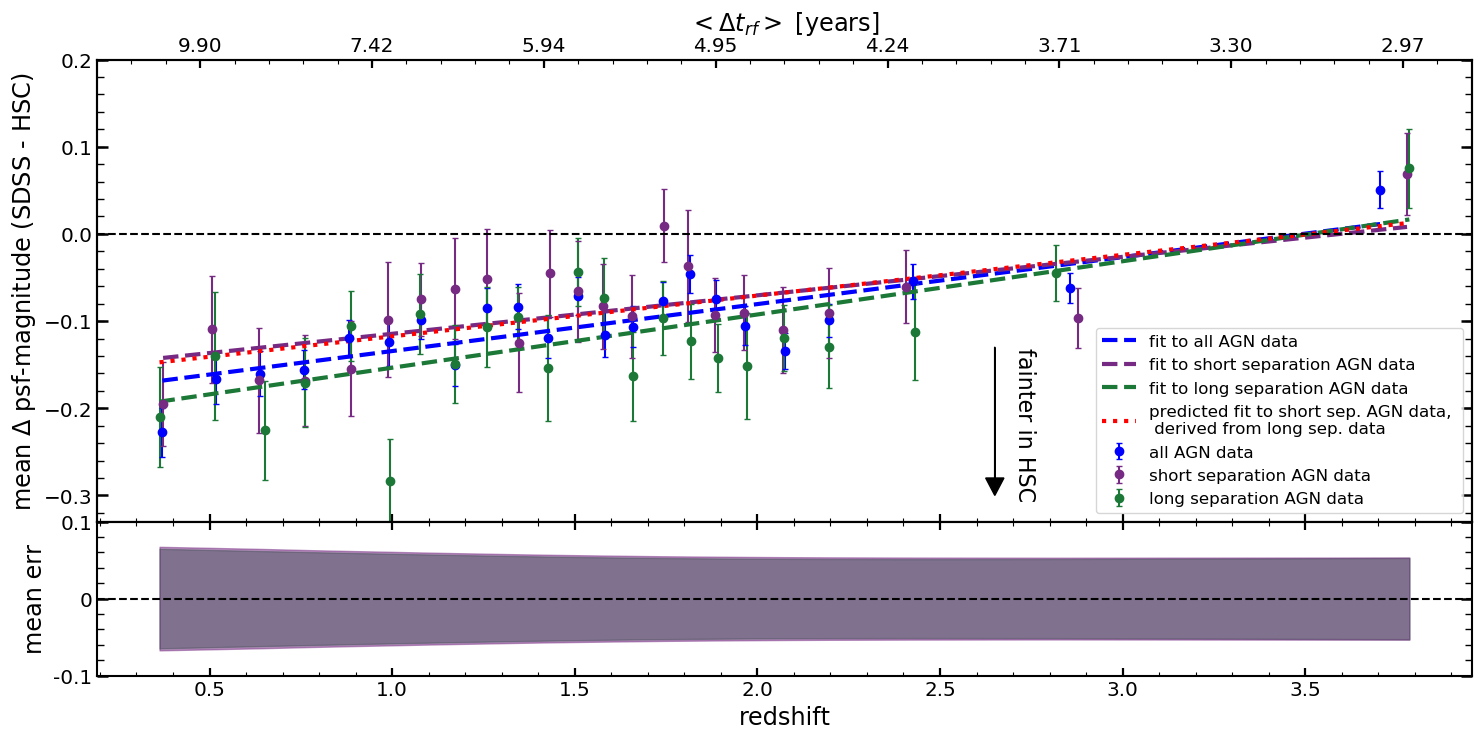

In [191]:
# Set up the axes with gridspec
fig = plt.figure(figsize=(24, 8))
grid = plt.GridSpec(4, 4, hspace=0., wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
err_ax = fig.add_subplot(grid[-1, 1:], yticklabels=[-0.1,0,0.1], sharex=main_ax)

ax2 = main_ax.twiny()

# scatter points on the main result
main_ax.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_array[0],yerr=res_delta_redshift_via_redshift_err_array[0],\
                 marker='o',capsize=2,ls='',color='blue',label='all AGN data')
# fit for the whole sample
main_ax.plot(res_redshift_array[0],p20_array_g[0][0],ls='--',color='blue',lw=3,label='fit to all AGN data')

# points for the short separation sample
main_ax.errorbar(res_redshift_short_separations_array[0],res_delta_redshift_via_redshift_short_separations_array[0],
             yerr=res_delta_redshift_via_redshift_err_short_separations_array[0],marker='o',capsize=2,ls='',color='#762a83',label='short separation AGN data')
# fit for the short separation sample
main_ax.plot(res_redshift_short_separations_array[0],p20_array_short_separations_g[0][0],ls='--',color='#762a83',lw=3,label='fit to short separation AGN data')

# points for the long separation sample
main_ax.errorbar(res_redshift_long_separations_array[0],res_delta_redshift_via_redshift_long_separations_array[0],
             yerr=res_delta_redshift_via_redshift_err_long_separations_array[0],marker='o',capsize=2,ls='',color='#1b7837',label='long separation AGN data')
# fit for the long separation sample
main_ax.plot(res_redshift_long_separations_array[0],p20_array_long_separations_g[0][0],ls='--',color='#1b7837',lw=3,label='fit to long separation AGN data')

# naive fit for the short separaiton data
main_ax.plot(res_redshift_long_separations_array[0],(0.1293/0.1689)*p20_array_long_separations_g[0][0],ls=':',
         color='red',lw=3,label='predicted fit to short sep. AGN data, \n derived from long sep. data')

main_ax.set_ylabel('mean $\Delta$ psf-magnitude (SDSS - HSC)')
main_ax.set_xlabel('redshift')
main_ax.set_ylim(-0.33,0.2)
main_ax.axhline(0,color='black',ls='--')
main_ax.legend()

main_ax.arrow(2.65,-0.13,-0.,-0.15,head_length=0.02,head_width=0.05,color='black')
main_ax.text(2.7,-0.15,'fainter in HSC',rotation=270,size=16)

ax2Xs = err_ax.get_xticks()
ax2.set_xticks(ax2Xs)
ax2.set_xticklabels(['',"%.2f" % round(14.85/(1+0.5),2) ,"%.2f" % round(14.85/(1+1),2),"%.2f" % round(14.85/(1+1.5),2),\
                     "%.2f" % round(14.85/(1+2),2),"%.2f" % round(14.85/(1+2.5),2),"%.2f" % round(14.85/(1+3),2),\
                     "%.2f" % round(14.85/(1+3.5),2),"%.2f" % round(14.85/(1+4),2)])
ax2.set_xlim(0.2,4.2)
ax2.set_xlabel('$<\Delta t_{rf}>$ [years]')

# prediction bands for the short and long separation sample
err_ax.fill_between(res_redshift_long_separations_array[0],lower_limit_long,upper_limit_long, color='#1b7837', alpha='0.5')
err_ax.fill_between(res_redshift_long_separations_array[0],lower_limit_short,upper_limit_short, color='#762a83', alpha='0.5')


err_ax.set_ylim(-0.1,0.1)
err_ax.axhline(0,color='black',ls='--')
err_ax.set_ylabel('mean err')
err_ax.set_xlabel('redshift')

plt.savefig(FIGURES_PDF_DIRECTORY + 'Figure4_time_separated.pdf', bbox_inches='tight')
plt.savefig(FIGURES_PNG_DIRECTORY + 'Figure4_time_separated.png', bbox_inches='tight')

# Figure 5 from the paper (modelling )

In [19]:
# load the data
means_all_LC_redshift_fit=np.load(DATA_DIRECTORY+'means_all_LC_redshift_fit.npy')
means_all_LC_redshift_values=np.load(DATA_DIRECTORY+'means_all_LC_redshift_values.npy')

In [37]:
# which frequency and slope values are avaliable

# frequency refers to the break in the PSD
# slope refers to the low frequency (long times) slope of the PSD
# see above (Section 4 for details)

freq_values=(np.unique(np.log10(means_all_LC_redshift_fit[:,0])))
slopes_values=np.unique(means_all_LC_redshift_fit[:,2])

In [21]:
# Here we do limited analysis for the purposes of this short letter so we only do 2d analysis
# Therefore we specify the lower limit of the Eddington ratio distribution and (later) the break in the Eddington ratio distribution
# Specify the value for the lower limit of the Eddington ratio distribution
L=-2.4

# create a bit finer result by interpolating where we did the simulations
res_detailed=[]
for v in np.concatenate((np.arange(-11,-8.0,3/30),np.array([-8]))):
    for a in np.concatenate((np.arange(0.55,1.45,0.9/30),np.array([1.45]))):
        # we multiply result with 2.5 as we are moving form dex to magnitude
        # we specify break in Eddington ratio at -1
        # we specify Edd. ratio that we are looking at at -0.8 i.e., 0.2 dex higher
        # result are self-similar (to large extent) no matter what exact values for break Edd. ratio and observed Edd. ratio are, as long as they are offset by same amount
        # the result of function ``create_interpolation_for_v_l_a_L_E'' is mean difference as a function of redshift
        # we ask for mean difference at redshift 0.3, what is the lowest redshift accesible in our sample
        res_detailed.append([v,a,2.5*create_interpolation_for_v_l_a_L_E(v,-1,a,L,-0.8,means_all_LC_redshift_fit,means_all_LC_redshift_values,complete_return=False,run=3)(0.3)])
        
res_detailed=np.array(res_detailed)

In [24]:
# we load few individual light curves (actually Eddington ratio curves) to illustrate the results
# We only provide these 3 file, as each file is 64 mb and there are 2401 examples
# Each file contains 2 light curves
# Very happy to provide further examples
LC_5325=np.load(DATA_DIRECTORY+'Modelling/Individual_LC/results_v_5_l_3_a_2_L_5_array_of_LC_16.npy')
LC_4335=np.load(DATA_DIRECTORY+'Modelling/Individual_LC/results_v_4_l_3_a_3_L_5_array_of_LC_16.npy')
LC_3345=np.load(DATA_DIRECTORY+'Modelling/Individual_LC/results_v_3_l_3_a_4_L_5_array_of_LC_16.npy')


In [31]:
# out of two light curves in each file we selected second (l=0 is also avaliable)
l=1
# how many point do we show
dt_max=100
# Find examples which correspond to the examples which we show in the parameters 2d plot, i.e., Edd. ratio =-.8
Edd=-0.8
positions_of_specific_Edd_ratio_LC_5325=np.nonzero((LC_5325[l][:len(LC_5325[l])-dt_max]>Edd)&(LC_5325[l][:len(LC_5325[l])-dt_max]<(Edd+0.1)))[0]
positions_of_specific_Edd_ratio_LC_4335=np.nonzero((LC_4335[l][:len(LC_4335[l])-dt_max]>Edd)&(LC_4335[l][:len(LC_4335[l])-dt_max]<(Edd+0.1)))[0]
positions_of_specific_Edd_ratio_LC_3345=np.nonzero((LC_3345[l][:len(LC_3345[l])-dt_max]>Edd)&(LC_3345[l][:len(LC_3345[l])-dt_max]<(Edd+0.1)))[0]

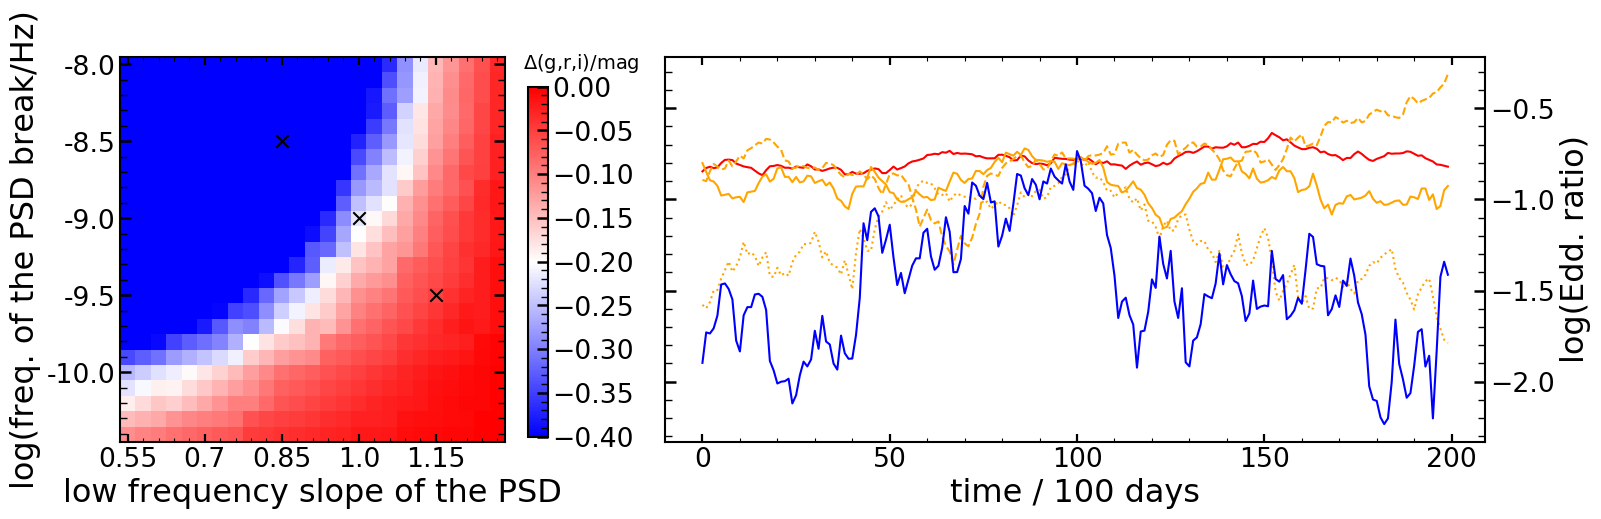

<Figure size 640x480 with 0 Axes>

In [38]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Fixing random state for reproducibility
np.random.seed(19680801)

fig, axScatter = plt.subplots(figsize=(20, 5))



# 2d parameter plot
# we cut a bit of an uninteresting region
img=axScatter.imshow(res_detailed[:,2].reshape(31,31)[6:,:-6],origin='lower',cmap='bwr',vmax=0,vmin=-0.40)
axScatter.imshow(res_detailed[:,2].reshape(31,31)[6:,:-6],origin='lower',cmap='bwr',vmax=0,vmin=-0.40)
axScatter.set_xticks(list(range(0,21,5)))
axScatter.set_yticks(range(4,25,5))
axScatter.set_xticklabels(slopes_values)
axScatter.set_yticklabels(freq_values[2:])


axScatter.set_xlabel('low frequency slope of the PSD')
axScatter.set_ylabel('log(freq. of the PSD break/Hz)')



axScatter.set_aspect(1.)
axScatter.scatter(x=[10,15,20],y=[19,14,9],color='black',marker='x',s=80)

divider = make_axes_locatable(axScatter)
axHisty = divider.append_axes("right", 8.2, pad=1.6)


axHisty.yaxis.set_tick_params(labelright=True,labelleft=False)
# individual examples selected to show typical behaviour
plt.plot(LC_3345[l][positions_of_specific_Edd_ratio_LC_3345[343]-100:positions_of_specific_Edd_ratio_LC_3345[343]+dt_max],color='red')
plt.plot(LC_4335[l][positions_of_specific_Edd_ratio_LC_4335[82947]-100:positions_of_specific_Edd_ratio_LC_4335[82947]+dt_max],ls='--',color='orange')
plt.plot(LC_4335[l][positions_of_specific_Edd_ratio_LC_4335[1316]-100:positions_of_specific_Edd_ratio_LC_4335[1316]+dt_max],ls=':',color='orange')
plt.plot(LC_4335[l][positions_of_specific_Edd_ratio_LC_4335[2000]-100:positions_of_specific_Edd_ratio_LC_4335[2000]+dt_max],ls='-',color='orange')
plt.plot(LC_5325[l][positions_of_specific_Edd_ratio_LC_5325[611]-100:positions_of_specific_Edd_ratio_LC_5325[611]+dt_max],color='blue')

axHisty.set_xlabel('time / 100 days')
axHisty.set_ylabel('log(Edd. ratio)')
axHisty.yaxis.set_label_position("right")


cax = fig.add_axes([0.375, 0.12, 0.01, 0.7])
clb=plt.colorbar(img,cax=cax)
clb.set_label('$\Delta$(g,r,i)/mag', labelpad=-38, y=1.10, rotation=0,fontsize=14)

axHisty.set_xticks([0, 50, 100,150,200])

plt.show()

plt.savefig(FIGURES_PDF_DIRECTORY + 'Figure5_delta_model.pdf', bbox_inches='tight')
plt.savefig(FIGURES_PNG_DIRECTORY + 'Figure5_delta_model.png', bbox_inches='tight')